# Fallback Table Metalearning



In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_06"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

In [5]:

source('functions_fallback.R')

# Load model predctions

In [6]:
predictions_df <- read.csv("../../data/tld_reseller_compare_predictions.csv")

dim(predictions_df)
head(predictions_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


In [7]:
# there exist 391 rows of predictions df (391 tld-reg) where all predicitions are n/a
# this correspnds with tld-reg in training data that do not have any domains in test data
predictions_df %>% filter(is.na(domain_id)) %>% dim()
vector <- predictions_df %>% filter(is.na(domain_id)) %>% pull(tld_registrar_index)
for (v in vector){
    cat(expiry_test_df_1 %>% filter(tld_registrar_index==v) %>% nrow())
}

[1] 391  12

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [8]:
predictions_df <- predictions_df %>% filter(!is.na(domain_id))
dim(predictions_df)

[1] 296709     12

In [9]:
dim(expiry_test_df_1)
expiry_test_predictions <- merge(expiry_test_df_1, 
      predictions_df,
     on = 'domain_id', all=TRUE)
dim(expiry_test_predictions)

[1] 296797     39

[1] 296797     47

In [10]:
expiry_test_predictions %>% filter(is.na(n)) %>% dim()

[1] 88 47

# Pull up reseller_geo

In [11]:
# system("gsutil cp gs://data_input/PredictiveModelAnalysis_ResellerGeoMap.csv /home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_ResellerGeoMap.csv")
geoLookupDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_ResellerGeoMap.csv")
# need to remove final row with all NAs
geoLookupDF <- geoLookupDF %>% filter_all(any_vars(!is.na(.)))
dim(geoLookupDF)
head(geoLookupDF)

[1] 1498    7

,start_date,end_date,reseller,reseller_am,reseller_country,registrar,reseller_geo
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,NA,Not Assigned,NA,NA,Others
2,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,007names,Varun,United States,007names,United States
3,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,0101 internet,Not Assigned,Hong Kong,0101 internet,China
4,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,1&1 internet,Neha,Germany,1&1 internet,EU
5,2018-01-01T00:00:00Z,2019-12-31T00:00:00Z,101 domain,Divya-Brands,United States,101 domain,United States
6,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,101domain discovery,Not Assigned,Germany,101domain discovery,EU


# Add reseller_geo to expiry_train_df_1 for fall_back gen

In [ ]:
expiry_train_df_1$reseller <- factor(expiry_train_df_1$reseller)
expiry_train_df_1$reseller_country <- factor(expiry_train_df_1$reseller_country)
expiry_train_df_1 <- as.data.frame(expiry_train_df_1)

# why result has more rows than input?
dim(expiry_train_df_1)
expiry_train_df_1 <- merge(expiry_train_df_1,
                                 geoLookupDF,
                                 on=c('reseller','reseller_country'), 
                                 all.x = TRUE)
dim(expiry_train_df_1)
head(expiry_train_df_1)


[1] 1188250      39

# Add reseller_geo to expiry_test_predictions

In [ ]:
expiry_test_predictions$reseller <- factor(expiry_test_predictions$reseller)
expiry_test_predictions$reseller_country <- factor(expiry_test_predictions$reseller_country)
expiry_test_predictions <- as.data.frame(expiry_test_predictions)

# why result has more rows than input?
dim(expiry_test_predictions)
expiry_test_predictions <- merge(expiry_test_predictions,
                                 geoLookupDF,
                                 on=c('reseller','reseller_country'), 
                                 all.x = TRUE)
dim(expiry_test_predictions)
head(expiry_test_predictions)


# Generate fallback table predictions

In [ ]:
npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_train_df_1, reseller_am_geo_map = geoLookupDF)

In [ ]:
# return list members to objects
names(npv_fallback_list)
for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]])

In [ ]:
expiry_test_predictions_2 <- fallback_app_1(test_data_op=expiry_test_predictions,
               in_col='pred_df_seg2_glm',
               out_col='pred_df_seg2_glm_fb')

dim(expiry_test_predictions)
dim(expiry_test_predictions_2)
head(expiry_test_predictions_2)

In [ ]:
# regmatches('pred_', names(expiry_test_predictions), invert = FALSE)
for (in_col in names(expiry_test_predictions)[grep('pred_',names(expiry_test_predictions))]){
    out_col = paste(in_col,'_fb',sep='')
    expiry_test_predictions <- fallback_app_1(test_data_op=expiry_test_predictions, in_col, out_col)
}


In [ ]:
dim(expiry_test_predictions)
head(expiry_test_predictions)

In [ ]:
expiry_test_predictions %>%
  select(names(expiry_test_predictions)[grep('pred_',names(expiry_test_predictions))]) %>%  # replace to your needs
  summarise_all(funs(sum(is.na(.)))) %>% t()

# Calculate overall performance metrics for models & fallback

In [20]:

lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=expiry_test_predictions,
                        dep_var = "renewal_status",
                        pred_var = "pred_df_seg2_glm") 

lift_list[["pred_df_seg2_glm"]] <- fallback_lift
auc_list[["pred_df_seg2_glm"]] <- calc_auc(lift_df=fallback_lift)

models <- names(expiry_test_predictions)[grep('pred_',names(expiry_test_predictions))]


for (model in models){
    model_lift <- chart_lift(pred_df=expiry_test_predictions,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift

In [ ]:
length(lift_list)
names(lift_list)
sapply(lift_list, dim)
lift_list["pred_df_seg2_glm"]

[1] 12

[1] "pred_df_seg2_glm"    "pred_df_seg_glm"     "pred_df_agg_glm"    
 [4] "pred_df_seg2_rf"     "pred_df_seg_rf"      "pred_df_agg_rf"     
 [7] "pred_df_seg2_glm_fb" "pred_df_seg_glm_fb"  "pred_df_agg_glm_fb" 
[10] "pred_df_seg2_rf_fb"  "pred_df_seg_rf_fb"   "pred_df_agg_rf_fb"

pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,pred_df_seg2_glm_fb,pred_df_seg_glm_fb,pred_df_agg_glm_fb,pred_df_seg2_rf_fb,pred_df_seg_rf_fb,pred_df_agg_rf_fb
10,10,10,10,10,10,10,10,10,10,10,10
4,4,4,4,4,4,4,4,4,4,4,4


P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12906,0.4715899,4.715899
0.2,18852,0.6888588,3.444294
0.3,22109,0.8078708,2.692903
0.4,24198,0.8842036,2.210509
0.5,25431,0.9292579,1.858516
0.6,26151,0.9555669,1.592612
0.7,26531,0.9694523,1.384932
0.8,26795,0.9790989,1.223874
0.9,26855,0.9812913,1.090324


In [ ]:
prop.table(table(expiry_test_df_1$renewal_status))


   Renewed Not Renewd 
0.09149351 0.90850649 

In [ ]:
plot_multigains <- function (lift_df_list=list(seg_glm = lift_df, 
                                               ben_dtr = lift_df_2),
                             auc_list = list(seg_glm = auc, 
                                             ben_dtr=auc_2),
                             prop_positive = 0.1121167) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


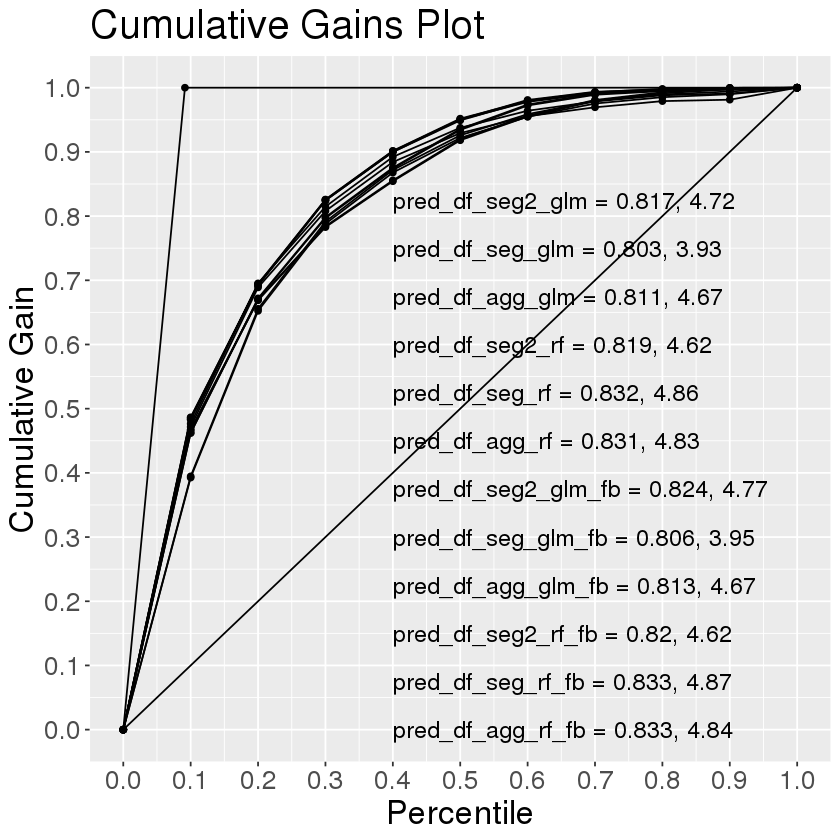

In [ ]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.09149351) 

In [ ]:
row.names(lift_df %>% filter(P==0.1) %>% select(contains("lift_")) %>% t())

[1] "lift_ seg2_glm"    "lift_ seg_glm"     "lift_ agg_glm"    
 [4] "lift_ seg2_rf"     "lift_ seg_rf"      "lift_ agg_rf"     
 [7] "lift_ seg2_glm_fb" "lift_ seg_glm_fb"  "lift_ agg_glm_fb" 
[10] "lift_ seg2_rf_fb"  "lift_ seg_rf_fb"   "lift_ agg_rf_fb"

In [ ]:
lift_df_tidy <- bind_cols(
    lift_df %>% filter(P==0.1) %>% select(contains("lift_")) %>% t() %>% head(6),
    lift_df %>% filter(P==0.1) %>% select(contains("lift_")) %>% t() %>% tail(6))
lift_df_tidy$model <- c('lift_seg2_glm','lift_seg_glm','lift_agg_glm',
                        'lift_seg2_rf','lift_seg_rf','lift_agg_rf')
names(lift_df_tidy) <- c('l10_orig','l10_fb','model')
lift_df_tidy <- lift_df_tidy %>% mutate(imprv = (l10_fb-l10_orig)/l10_orig)
lift_df_tidy

New names:
* NA -> ...1
* NA -> ...2



l10_orig,l10_fb,model,imprv
"<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>"
4.715899,4.765959,lift_seg2_glm,0.010615218
3.925896,3.945993,lift_seg_glm,0.005119136
4.666204,4.671685,lift_agg_glm,0.001174628
4.619798,4.624548,lift_seg2_rf,0.001028237
4.857675,4.865714,lift_seg_rf,0.001654882
4.829539,4.835751,lift_agg_rf,0.001286222


In [ ]:
auc_df_tidy <- bind_cols(
    as.data.frame(auc_list) %>% t() %>% head(6),
    as.data.frame(auc_list) %>% t() %>% tail(6))
auc_df_tidy$model <- c('auc_seg2_glm','auc_seg_glm','auc_agg_glm',
                        'auc_seg2_rf','auc_seg_rf','auc_agg_rf')
names(auc_df_tidy) <- c('auc_orig','auc_fb','model')
auc_df_tidy <- auc_df_tidy %>% mutate(imprv = (auc_fb-auc_orig)/auc_orig)
auc_df_tidy



New names:
* NA -> ...1
* NA -> ...2



auc_orig,auc_fb,model,imprv
"<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>"
0.8167190,0.8238152,auc_seg2_glm,0.008688591
0.8027497,0.8061041,auc_seg_glm,0.004178644
0.8113440,0.8126338,auc_agg_glm,0.001589800
0.8190357,0.8203329,auc_seg2_rf,0.001583793
0.8315727,0.8328480,auc_seg_rf,0.001533550
0.8314704,0.8327530,auc_agg_rf,0.001542528


# Generate one prediction column for each fallback table
## to determine when which table is most appropriate

In [ ]:
expiry_test_predictions<-expiry_test_predictions %>% mutate(
    temp_index = paste(tld, reseller_geo, reg_arpt_slab, sep = ""),
    npv_fallback_first_geo_arpt_tld = npv_fallback_first_geo_arpt_tld$renewal_rate[match(temp_index, 
                                                npv_fallback_first_geo_arpt_tld$index)]
)

expiry_test_predictions<-expiry_test_predictions %>% mutate(
    temp_index = paste(reseller_geo, reg_arpt_slab, sep = ""),
    npv_fallback_first_geo_arpt = npv_fallback_first_geo_arpt$renewal_rate[match(temp_index, 
                                                npv_fallback_first_geo_arpt$index)]
)

expiry_test_predictions<-expiry_test_predictions %>% mutate(
    temp_index = paste(tld, reg_arpt_slab, sep = ""),
    npv_fallback_first_tld_arpt = npv_fallback_first_tld_arpt$renewal_rate[match(temp_index, 
                                                npv_fallback_first_tld_arpt$index)]
)

expiry_test_predictions<-expiry_test_predictions %>% mutate(
    temp_index = paste(region, reg_arpt_slab, sep = ""),
    npv_fallback_first_final = npv_fallback_first_final$renewal_rate[match(temp_index, 
                                                npv_fallback_first_final$index)]
)

expiry_test_predictions<-expiry_test_predictions %>% select(-temp_index)

head(expiry_test_predictions)

,reseller,registrar,reseller_country,domain_id,domain,tld_registrar_index,renewal_type,renewed_count,expiry_date,creation_date,status,tld,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,⋯,pattern_score,pattern_domain_count,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,n,start_date,end_date,reseller_am,reseller_geo,reg_arpt_slab,pred_df_seg2_glm_fb,pred_df_seg_glm_fb,pred_df_agg_glm_fb,pred_df_seg2_rf_fb,pred_df_seg_rf_fb,pred_df_agg_rf_fb,npv_fallback_first_geo_arpt_tld,npv_fallback_first_geo_arpt,npv_fallback_first_tld_arpt,npv_fallback_first_final
,<fct>,<chr>,<fct>,<int>,<chr>,<chr>,<chr>,<int>,<date>,<date>,<chr>,<fct>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,⋯,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 internet,1&1 internet,Germany,92459593,penrosetile.store,store1&1 internet,FirstTime,1,2020-02-01,2019-02-01,Active,store,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-01,1&1 Internet,1&1 Internet,15,15.0000,1,⋯,0.062500000,1,Renewed,0.5069604,0.534,0.558,0.4878033,0.4981100,0.4763754,765,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(10,15]",0.5069604,0.534,0.558,0.4878033,0.4981100,0.4763754,NA,0.512,0.549,0.493
2,1&1 internet,1&1 internet,Germany,91070293,alcantarapalma.online,online1&1 internet,FirstTime,1,2020-01-15,2019-01-15,Active,online,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,1&1 Internet,1&1 Internet,0,0.0001,1,⋯,0.001600000,1,Not Renewd,0.4234759,0.425,0.374,0.5154490,0.5268478,0.5192867,8041,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(-Inf,0]",0.4234759,0.425,0.374,0.5154490,0.5268478,0.5192867,0.149,0.122,0.125,0.129
3,1&1 internet,1&1 internet,Germany,92243793,layerfarms.online,online1&1 internet,FirstTime,1,2020-01-30,2019-01-30,Active,online,Non China,1,NA,Renewed,0,renewal,NA,2019-05-19,1&1 Internet,1&1 Internet,1,1.0000,1,⋯,0.031250000,2,Renewed,0.4671778,0.485,0.475,0.3369761,0.3348900,0.3264582,8041,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(0.3,1]",0.4671778,0.485,0.475,0.3369761,0.3348900,0.3264582,0.252,0.081,0.099,0.057
4,1&1 internet,1&1 internet,Germany,92382343,koiunyq.online,online1&1 internet,FirstTime,1,2020-01-31,2019-01-31,Deleted,online,Non China,1,NA,Not Renewd,0,NA,NA,NA,Not Assigned,Not Assigned,1,1.0000,NA,⋯,0.012345679,1,Not Renewd,0.5380713,0.547,0.508,0.3168814,0.3273583,0.4140139,8041,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(0.3,1]",0.5380713,0.547,0.508,0.3168814,0.3273583,0.4140139,0.252,0.081,0.099,0.057
5,1&1 internet,1&1 internet,Germany,89480877,e-move24.online,online1&1 internet,FirstTime,1,2020-01-02,2019-01-02,Active,online,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-02,1&1 Internet,1&1 Internet,0,0.0001,1,⋯,0.003086420,1,Renewed,0.4357224,0.450,0.292,0.5910136,0.5345685,0.5278744,8041,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(-Inf,0]",0.4357224,0.450,0.292,0.5910136,0.5345685,0.5278744,0.149,0.122,0.125,0.129
6,1&1 internet,1&1 internet,Germany,90751138,votenigeriang.online,online1&1 internet,FirstTime,1,2020-01-12,2019-01-12,Active,online,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-12,1&1 Internet,1&1 Internet,0,0.0001,1,⋯,0.002066116,1,Renewed,0.4415465,0.444,0.385,0.4651246,0.4706303,0.4768728,8041,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(-Inf,0]",0.4415465,0.444,0.385,0.4651246,0.4706303,0.4768728,0.149,0.122,0.125,0.129


# Generate Metrics @ Tld-Reseller level 

In [ ]:
l10_dplyr <- function (pred_df,
                              pred_var = "first_renewal_prediction") {
  N <- 10  # total number of rows to preallocate--possibly an overestimate
  lift_df <- data.frame(P =rep(NA, N), 
                        actu_renwd2=rep(NA, N), 
                        gain=rep(NA, N), 
                        lift=rep(NA, N), 
                        stringsAsFactors=FALSE)          # you don't know levels yet
  actu_renwd <- sum(pred_df[["renewal_status"]]=='Renewed')
  
  i = 1
  for(P in seq(.1,1,length=10)){
    temp_df <- data.frame(pred_df)[c("renewal_status",pred_var)]
    ttmp_df <- temp_df[order(temp_df[pred_var],decreasing = TRUE),][1:round(dim(temp_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[["renewal_status"]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    
    lift_df[i, ] <- list(P, actu_renwd2, gain, lift)
    i = i+1
  }
  return(lift_df %>% filter(P==0.1) %>% pull(lift))
}

auc_dplyr <- function (pred_df,
                              pred_var = "first_renewal_prediction") {
  N <- 10  # total number of rows to preallocate--possibly an overestimate
  lift_df <- data.frame(P =rep(NA, N), 
                        actu_renwd2=rep(NA, N), 
                        gain=rep(NA, N), 
                        lift=rep(NA, N), 
                        stringsAsFactors=FALSE)          # you don't know levels yet
  actu_renwd <- sum(pred_df[["renewal_status"]]=='Renewed')
  
  i = 1
  for(P in seq(.1,1,length=10)){
    temp_df <- data.frame(pred_df)[c("renewal_status",pred_var)]
    ttmp_df <- temp_df[order(temp_df[pred_var],decreasing = TRUE),][1:round(dim(temp_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[["renewal_status"]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    
    lift_df[i, ] <- list(P, actu_renwd2, gain, lift)
    i = i+1
  }
  return(calc_auc(lift_df))
}

In [ ]:
names(expiry_test_predictions)

[1] "reseller"                        "registrar"                      
 [3] "reseller_country"                "domain_id"                      
 [5] "domain"                          "tld_registrar_index"            
 [7] "renewal_type"                    "renewed_count"                  
 [9] "expiry_date"                     "creation_date"                  
[11] "status"                          "tld"                            
[13] "region"                          "reg_period"                     
[15] "registrant_country"              "renewal_status"                 
[17] "renew_mbg"                       "renew_type"                     
[19] "autorenew_type"                  "renew_date"                     
[21] "renew_registrar"                 "renew_reseller"                 
[23] "reg_revenue"                     "reg_arpt"                       
[25] "renew_period"                    "renew_domain_revenue"           
[27] "renew_arpt"                      "reg_arpt_org"                   
[29] "sld"                             "sld_type"                       
[31] "sld_length"                      "sld_type2"                      
[33] "day_domains"                     "log_reg_arpt"                   
[35] "gibb_score"                      "pattern"                        
[37] "cluster"                         "pattern_score"                  
[39] "pattern_domain_count"            "actual"                         
[41] "pred_df_seg2_glm"                "pred_df_seg_glm"                
[43] "pred_df_agg_glm"                 "pred_df_seg2_rf"                
[45] "pred_df_seg_rf"                  "pred_df_agg_rf"                 
[47] "n"                               "start_date"                     
[49] "end_date"                        "reseller_am"                    
[51] "reseller_geo"                    "reg_arpt_slab"                  
[53] "pred_df_seg2_glm_fb"             "pred_df_seg_glm_fb"             
[55] "pred_df_agg_glm_fb"              "pred_df_seg2_rf_fb"             
[57] "pred_df_seg_rf_fb"               "pred_df_agg_rf_fb"              
[59] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_geo_arpt"    
[61] "npv_fallback_first_tld_arpt"     "npv_fallback_first_final"

In [66]:
# expiry_test_metrics <- expiry_test_predictions %>%
#   group_by(tld_registrar_index) %>%
#   do( l10_seg2_glm = l10_dplyr(., pred_var = "pred_df_seg2_glm"),
#       l10_seg_glm = l10_dplyr(., pred_var = "pred_df_seg_glm"),
#        l10_agg_glm = l10_dplyr(., pred_var = "pred_df_agg_glm"),
#        l10_seg2_rf = l10_dplyr(., pred_var = "pred_df_seg2_rf"),
#        l10_seg_rf = l10_dplyr(., pred_var = "pred_df_seg_rf"),
#        l10_agg_rf = l10_dplyr(., pred_var = "pred_df_agg_rf"),
     
#       auc_seg2_glm = auc_dplyr(., pred_var = "pred_df_seg2_glm"),
#       auc_seg_glm = auc_dplyr(., pred_var = "pred_df_seg_glm"),
#        auc_agg_glm = auc_dplyr(., pred_var = "pred_df_agg_glm"),
#        auc_seg2_rf = auc_dplyr(., pred_var = "pred_df_seg2_rf"),
#        auc_seg_rf = auc_dplyr(., pred_var = "pred_df_seg_rf"),
#        auc_agg_rf = auc_dplyr(., pred_var = "pred_df_agg_rf"),
      
#      l10_seg2_glm_fb = l10_dplyr(., pred_var = "pred_df_seg2_glm_fb"),
#       l10_seg_glm_fb = l10_dplyr(., pred_var = "pred_df_seg_glm_fb"),
#        l10_agg_glm_fb = l10_dplyr(., pred_var = "pred_df_agg_glm_fb"),
#        l10_seg2_rf_fb = l10_dplyr(., pred_var = "pred_df_seg2_rf_fb"),
#        l10_seg_rf_fb = l10_dplyr(., pred_var = "pred_df_seg_rf_fb"),
#        l10_agg_rf_fb = l10_dplyr(., pred_var = "pred_df_agg_rf_fb"),
     
#       auc_seg2_glm_fb = auc_dplyr(., pred_var = "pred_df_seg2_glm_fb"),
#       auc_seg_glm_fb = auc_dplyr(., pred_var = "pred_df_seg_glm_fb"),
#        auc_agg_glm_fb = auc_dplyr(., pred_var = "pred_df_agg_glm_fb"),
#        auc_seg2_rf_fb = auc_dplyr(., pred_var = "pred_df_seg2_rf_fb"),
#        auc_seg_rf_fb = auc_dplyr(., pred_var = "pred_df_seg_rf_fb"),
#        auc_agg_rf_fb = auc_dplyr(., pred_var = "pred_df_agg_rf_fb"),
#       )

In [69]:
# head(expiry_test_metrics)

In [68]:
# save(expiry_test_metrics, file="../../data/output/expiry_test_metrics_101020")
# system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/ ")
# system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")

In [34]:
# load("../../data/expiry_test_metrics_101020")

In [70]:
dim(expiry_test_metrics)
head(expiry_test_metrics)

[1] 1405   25

tld_registrar_index,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb
<chr>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
fun1&1 internet,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6
fun10dencehispahard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fun1api,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25
funactive 24,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63
funalibaba,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023
funalibaba sg,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95


# Metalearning Prep

## add geo to training data for fetaure eng

In [71]:
# system("gsutil cp gs://data_input/PredictiveModelAnalysis_AnomalyRegistrars.csv /home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- apply(anomalyDF, 2, function(x) trimws(x,which = c("both")) )
geoLookupDF <- unique(anomalyDF[,c('reseller','reseller_country','reseller_geo')])
geoLookupDF <- as.data.frame(geoLookupDF)
expiry_test_df_1 <- merge(expiry_test_df_1,geoLookupDF,on=c('reseller','reseller_country'), all.x = TRUE)

In [74]:
# expiry_test_df_1 %>% setnames("reseller_geo.x", "reseller_geo")

In [75]:
head(expiry_test_df_1)

reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo,reseller_geo.y
<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>,<fct>
1&1 internet,Germany,FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15.00,1,15,15,15.00,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1,EU,EU
1&1 internet,Germany,FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15.00,1,15,15,15.00,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1,EU,EU
1&1 internet,Germany,FirstTime,1,2020-04-23,101353454,cloudnodes.host,2019-04-23,Deleted,host,1&1 internet,Non China,1,NA,Not Renewd,0,NA,NA,NA,Not Assigned,Not Assigned,65,65.00,NA,0,NA,65.00,host1&1 internet,cloudnodes,l,10,10l,1,4.174387,3.83,cloudnodes,1,1,1,EU,EU
1&1 internet,Germany,FirstTime,1,2020-02-18,44554288,agenciaseo.online,2017-02-18,Active,online,1&1 internet,Non China,3,NA,Renewed,0,auto-renewal,realized,2020-02-18,1&1 Internet,1&1 Internet,55,18.33,1,25,25,18.33,online1&1 internet,agenciaseo,l,10,10l,1,2.908539,4.52,agenciaseo,1,1,1,EU,EU
1&1 internet,Germany,FirstTime,1,2020-03-29,46343989,launion.online,2017-03-29,Active,online,1&1 internet,Non China,3,NA,Renewed,0,renewal,NA,2020-03-25,1&1 Internet,1&1 Internet,55,18.33,1,25,25,18.33,online1&1 internet,launion,l,7,7l,1,2.908539,6.26,launion,1,1,1,EU,EU
1&1 internet,Germany,FirstTime,1,2020-04-29,47376325,egyptar.online,2017-04-29,Deleted,online,1&1 internet,Non China,3,NA,Not Renewd,0,NA,NA,NA,Not Assigned,Not Assigned,50,16.67,NA,0,NA,16.67,online1&1 internet,egyptar,l,7,7l,1,2.813611,1.73,egyptar,1,1,1,EU,EU


## Feature Engineering for tld-reseller level 

In [76]:
# new geo level feature eng
expiry_test_meta = expiry_test_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(
            geo_maj = reseller_geo[n == max(n)][1],
            geo_cnt = n_distinct(reseller_geo),
            n = n(),
            ren_prp = sum(renewal_status=='Renewed')/sum(n),
            tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n,
              
            daydom_min = min(day_domains), 
            daydom_max = max(day_domains), 
            daydom_mean = mean(day_domains, na.rm = TRUE), 
            daydom_rng = daydom_max - daydom_min, 
            daydom_std = sd(day_domains, na.rm = TRUE), 
            daydom_skew = skewness(day_domains, na.rm = TRUE), 
            daydom_kurt = kurtosis(day_domains, na.rm = TRUE),

            sldlen_min = min(sld_length), 
            sldlen_max = max(sld_length), 
            sldlen_mean = mean(sld_length, na.rm = TRUE), 
            sldlen_rng = sldlen_max - sldlen_min, 
            sldlen_std = sd(sld_length, na.rm = TRUE), 
            sldlen_skew = skewness(sld_length, na.rm = TRUE), 
            sldlen_kurt = kurtosis(sld_length, na.rm = TRUE),
  
            gibbs_min = min(gibb_score), 
            gibbs_max = max(gibb_score), 
            gibbs_mean = mean(gibb_score, na.rm = TRUE), 
            gibbs_rng = gibbs_max - gibbs_min, 
            gibbs_std = sd(gibb_score, na.rm = TRUE), 
            gibbs_skew = skewness(gibb_score, na.rm = TRUE), 
            gibbs_kurt = kurtosis(gibb_score, na.rm = TRUE),
  
            pdcnt_min = min(pattern_domain_count), 
            pdcnt_max = max(pattern_domain_count), 
            pdcnt_mean = mean(pattern_domain_count, na.rm = TRUE), 
            pdcnt_rng = pdcnt_max - pdcnt_min, 
            pdcnt_std = sd(pattern_domain_count, na.rm = TRUE), 
            pdcnt_skew = skewness(pattern_domain_count, na.rm = TRUE), 
            pdcnt_kurt = kurtosis(pattern_domain_count, na.rm = TRUE),
  
            regarpt_min = min(reg_arpt), 
            regarpt_max = max(reg_arpt), 
            regarpt_mean = mean(reg_arpt, na.rm = TRUE), 
            regarpt_rng = regarpt_max - regarpt_min, 
            regarpt_std = sd(reg_arpt, na.rm = TRUE), 
            regarpt_skew = skewness(reg_arpt, na.rm = TRUE), 
            regarpt_kurt = kurtosis(reg_arpt, na.rm = TRUE))
dim(expiry_test_meta)
head(expiry_test_meta)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 1405   42

tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt
<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,0.8626703,3.890973e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,3.8820162,-1.821837e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,1.1172287,0.000000e+00,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,5.00,5.00,5.0000000,0.00,0.00000000,NaN,NaN
funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,20.4690367,3.916190e+00,14.4351125,1,3,1.272727,2,0.7025002,1.976412,2.003371,0.50,0.50,0.5000000,0.00,0.00000000,NaN,NaN
funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,21.0541141,4.158734e+00,15.5656248,1,74,5.124341,73,9.7106897,4.178197,19.706420,0.75,4.75,0.7519112,4.00,0.07918874,48.370853,2363.819659
funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,3.3497910,1.008842e+00,0.7044306,1,1,1.000000,0,0.0000000,NaN,NaN,0.75,8.50,1.2656250,7.75,1.92931065,3.280409,9.359645


In [77]:
# add a handful more vars 
country_maj = expiry_test_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

country_cnt = expiry_test_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

region_maj = expiry_test_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

region_cnt = expiry_test_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

expiry_test_meta = expiry_test_meta %>% 
    mutate(country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,
            )

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [78]:
dim(expiry_test_meta)
head(expiry_test_meta)

[1] 1405   46

tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt,country_maj,region_maj,country_cnt,region_cnt
<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,0.8626703,3.890973e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN,Japan,Non China,1,1
fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,3.8820162,-1.821837e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN,China,China,1,1
fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,1.1172287,0.000000e+00,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,5.00,5.00,5.0000000,0.00,0.00000000,NaN,NaN,United States,Non China,1,1
funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,20.4690367,3.916190e+00,14.4351125,1,3,1.272727,2,0.7025002,1.976412,2.003371,0.50,0.50,0.5000000,0.00,0.00000000,NaN,NaN,United States,Non China,1,1
funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,21.0541141,4.158734e+00,15.5656248,1,74,5.124341,73,9.7106897,4.178197,19.706420,0.75,4.75,0.7519112,4.00,0.07918874,48.370853,2363.819659,United States,Non China,1,1
funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,3.3497910,1.008842e+00,0.7044306,1,1,1.000000,0,0.0000000,NaN,NaN,0.75,8.50,1.2656250,7.75,1.92931065,3.280409,9.359645,France,Non China,1,1


# Join w/ Metrics

In [79]:
expiry_test_metametrics <- merge(expiry_test_meta, expiry_test_metrics, on = 'tld_registrar_index', all = TRUE)

dim(expiry_test_metametrics)
head(expiry_test_metametrics)

[1] 1405   70

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,region_cnt,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,1,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,1,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,1,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,1,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,1,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95


# Metalearning w/ Fallback -- BINARY
## seg2_glm_fb vs agg_rf_fb
### Issue: for all tld-reg in test data, seg2_glm_fb outperforms agg_rf_fb even though agg_rf_fb outperforms overall

In [46]:
# still need to investigate why 88 NA's for agg_rf sans fallback

In [80]:
# (auc_vars = grep('auc', names(metrics_df), value=TRUE))
# (l10_vars = grep('l10', names(metrics_df), value=TRUE))

auc_vars = c('auc_seg2_glm_fb','auc_agg_rf_fb')
l10_vars = c('l10_seg2_glm_fb','l10_agg_rf_fb')

expiry_test_metametrics <- expiry_test_metametrics %>%
    mutate (auc_win_01=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win_01=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                              
head(expiry_test_metametrics)

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_win_01,l10_win_01
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<chr>,<chr>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,auc_seg2_glm_fb,l10_seg2_glm_fb
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,auc_seg2_glm_fb,l10_seg2_glm_fb
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,auc_agg_rf_fb,l10_agg_rf_fb
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,auc_agg_rf_fb,l10_agg_rf_fb
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,auc_agg_rf_fb,l10_agg_rf_fb


In [81]:
table(expiry_test_metametrics$auc_win_01)
table(expiry_test_metametrics$l10_win_01)


  auc_agg_rf_fb auc_seg2_glm_fb 
            406             692 


  l10_agg_rf_fb l10_seg2_glm_fb 
            236             862 

# Metalearning w/ Fallback -- MULTICLASS
## s
### Issue: for all tld-reg in test data, seg2_glm_fb outperforms agg_rf_fb even though agg_rf_fb outperforms overall

In [83]:
(auc_vars = grep('auc_', names(expiry_test_metametrics), value=TRUE))
(l10_vars = grep('l10_', names(expiry_test_metametrics), value=TRUE))

(auc_vars = auc_vars[-grep("win", auc_vars)])
(l10_vars = l10_vars[-grep("win", l10_vars)])

# auc_vars = c('auc_seg2_glm_fb','auc_agg_rf_fb')
# l10_vars = c('l10_seg2_glm_fb','l10_agg_rf_fb')

expiry_test_metametrics <- expiry_test_metametrics %>%
    mutate (auc_win_02=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win_02=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                              
head(expiry_test_metametrics)

[1] "auc_seg2_glm"    "auc_seg_glm"     "auc_agg_glm"     "auc_seg2_rf"    
 [5] "auc_seg_rf"      "auc_agg_rf"      "auc_seg2_glm_fb" "auc_seg_glm_fb" 
 [9] "auc_agg_glm_fb"  "auc_seg2_rf_fb"  "auc_seg_rf_fb"   "auc_agg_rf_fb"  
[13] "auc_win_01"

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "l10_seg2_glm_fb" "l10_seg_glm_fb" 
 [9] "l10_agg_glm_fb"  "l10_seg2_rf_fb"  "l10_seg_rf_fb"   "l10_agg_rf_fb"  
[13] "l10_win_01"

[1] "auc_seg2_glm"    "auc_seg_glm"     "auc_agg_glm"     "auc_seg2_rf"    
 [5] "auc_seg_rf"      "auc_agg_rf"      "auc_seg2_glm_fb" "auc_seg_glm_fb" 
 [9] "auc_agg_glm_fb"  "auc_seg2_rf_fb"  "auc_seg_rf_fb"   "auc_agg_rf_fb"

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "l10_seg2_glm_fb" "l10_seg_glm_fb" 
 [9] "l10_agg_glm_fb"  "l10_seg2_rf_fb"  "l10_seg_rf_fb"   "l10_agg_rf_fb"

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_win_01,l10_win_01,auc_win_02,l10_win_02
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<chr>,<chr>,<chr>,<chr>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_glm,l10_seg2_glm
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,NA,NA
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_rf,l10_seg2_rf
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_seg2_rf
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_agg_rf
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_glm,l10_agg_glm


In [84]:
table(expiry_test_metametrics$auc_win_02)
table(expiry_test_metametrics$l10_win_02)


    auc_agg_glm      auc_agg_rf     auc_seg_glm      auc_seg_rf    auc_seg2_glm 
            148              94             177             119             469 
auc_seg2_glm_fb     auc_seg2_rf 
              3              88 


    l10_agg_glm      l10_agg_rf     l10_seg_glm      l10_seg_rf    l10_seg2_glm 
            116              38             157              52             637 
l10_seg2_glm_fb     l10_seg2_rf 
              1              97 

In [85]:
# expiry_test_metametrics %>% 
#     group_by(auc_win_02) %>%
#     tally() %>%
#     arrange(desc(n))

# expiry_test_metametrics %>% 
#     group_by(l10_win_02) %>%
#     tally() %>%
#     arrange(desc(n))

In [86]:
# Interesting that in 3 (1) cases, the fallback version outperforms original version of seg2_glm
# But these are all cases where the models tied and which.max simply picked the first index
expiry_test_metametrics %>% filter(auc_win_02 == 'auc_seg2_glm_fb') %>% select(auc_vars)
expiry_test_metametrics %>% filter(l10_win_02 == 'l10_seg2_glm_fb') %>% select(auc_vars)

auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb
<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
0.45,0.475,0.475,0.375,0.375,0.325,0.55,0.475,0.475,0.375,0.375,0.325
0.4642857,0.4928571,0.4928571,0.4642857,0.4928571,0.4928571,0.5785714,0.4928571,0.4928571,0.4642857,0.4928571,0.4928571
0.15,0.25,0.4,0.5,0.5,0.5,0.55,0.25,0.4,0.5,0.5,0.5


auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb
<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
0.4642857,0.4928571,0.4928571,0.4642857,0.4928571,0.4928571,0.5785714,0.4928571,0.4928571,0.4642857,0.4928571,0.4928571


In [88]:
## test another auc_win and l10_win with just seg2_glm fallback and non fallback

(auc_vars = grep('auc_seg2_glm', names(expiry_test_metametrics), value=TRUE))
(l10_vars = grep('l10_seg2_glm', names(expiry_test_metametrics), value=TRUE))

# (auc_vars = auc_vars[-grep("win", auc_vars)])
# (l10_vars = l10_vars[-grep("win", l10_vars)])

# auc_vars = c('auc_seg2_glm_fb','auc_agg_rf_fb')
# l10_vars = c('l10_seg2_glm_fb','l10_agg_rf_fb')

expiry_test_metametrics <- expiry_test_metametrics %>%
    mutate (auc_win_03=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win_03=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                              
head(expiry_test_metametrics)

[1] "auc_seg2_glm"    "auc_seg2_glm_fb"

[1] "l10_seg2_glm"    "l10_seg2_glm_fb"

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_win_01,l10_win_01,auc_win_02,l10_win_02,auc_win_03,l10_win_03
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_glm,l10_seg2_glm,auc_seg2_glm,l10_seg2_glm
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,NA,NA,NA,NA
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_agg_rf,auc_seg2_glm,l10_seg2_glm
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_glm,l10_agg_glm,auc_seg2_glm,l10_seg2_glm


In [89]:
table(expiry_test_metametrics$auc_win_03)
table(expiry_test_metametrics$l10_win_03)


   auc_seg2_glm auc_seg2_glm_fb 
           1085              13 


   l10_seg2_glm l10_seg2_glm_fb 
           1094               4 

In [92]:
# Interesting that in 3 (1) cases, the fallback version outperforms original version of seg2_glm
# But these are all cases where the models tied and which.max simply picked the first index
expiry_test_metametrics %>% filter(auc_win_03 == 'auc_seg2_glm_fb') %>% select(tld_registrar_index,n,auc_vars)
expiry_test_metametrics %>% filter(l10_win_03 == 'l10_seg2_glm_fb') %>% select(tld_registrar_index,n,auc_vars)

tld_registrar_index,n,auc_seg2_glm,auc_seg2_glm_fb
<chr>,<int>,<list>,<list>
funeranet,269,0.75,0.95
onlinedomeneshop,18,0.57,0.59
onlinehosting concepts,20,0.4857143,0.4928571
siteatak,26,0.45,0.55
space1api,8,0.275,0.3
spacemat bao,2,0.25,0.95
storegandi sas,32,0.4166667,0.65
storenamesco,25,0.4642857,0.5785714
techaruba,7,0.55,0.5833333


tld_registrar_index,n,auc_seg2_glm,auc_seg2_glm_fb
<chr>,<int>,<list>,<list>
funeranet,269,0.75,0.95
spacemat bao,2,0.25,0.95
storenamesco,25,0.4642857,0.5785714
techdomainesia,9,0.15,0.55


In [110]:
# examine renewal_status dist and NAs for these tld-reg

(tld_regs <- c( expiry_test_metametrics %>% 
    filter(auc_win_03 == 'auc_seg2_glm_fb') %>% 
    pull(tld_registrar_index), 
              expiry_test_metametrics %>% 
    filter(auc_win_03 == 'l10_seg2_glm_fb') %>% 
    pull(tld_registrar_index)))

# all have both renewed and not renewed domains
expiry_test_predictions %>% 
  filter(tld_registrar_index %in% tld_regs) %>% 
  select(tld_registrar_index, renewal_status, pred_df_seg2_glm, pred_df_seg2_glm_fb) %>% 
  group_by(tld_registrar_index, renewal_status) %>% 
     summarise(n = n())%>%
     mutate(freq = n / sum(n))

[1] "funeranet"              "onlinedomeneshop"       "onlinehosting concepts"
 [4] "siteatak"               "space1api"              "spacemat bao"          
 [7] "storegandi sas"         "storenamesco"           "techaruba"             
[10] "techdomainesia"         "techmoniker"            "websitechengdu west"   
[13] "websiteporkbun"

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



tld_registrar_index,renewal_status,n,freq
<chr>,<fct>,<int>,<dbl>
funeranet,Renewed,1,0.003717472
funeranet,Not Renewd,268,0.996282528
onlinedomeneshop,Renewed,10,0.555555556
onlinedomeneshop,Not Renewd,8,0.444444444
onlinehosting concepts,Renewed,28,0.700000000
onlinehosting concepts,Not Renewd,12,0.300000000
siteatak,Renewed,4,0.153846154
siteatak,Not Renewd,22,0.846153846
space1api,Renewed,4,0.500000000


In [113]:
expiry_test_predictions %>% 
  filter(tld_registrar_index %in% tld_regs) %>% 
  select(tld_registrar_index, renewal_status, pred_df_seg2_glm, pred_df_seg2_glm_fb) %>% 
  group_by(tld_registrar_index) %>% 
  select(pred_df_seg2_glm) %>%  # replace to your needs
  summarise_all(funs(sum(is.na(.))))

Adding missing grouping variables: `tld_registrar_index`



tld_registrar_index,pred_df_seg2_glm
<chr>,<int>
funeranet,269
onlinedomeneshop,1
onlinehosting concepts,2
siteatak,1
space1api,1
spacemat bao,2
storegandi sas,2
storenamesco,1
techaruba,1


In [115]:
expiry_test_predictions %>% filter(tld_registrar_index=='onlinedomeneshop') %>% select(
    tld_registrar_index, domain, renewal_status, pred_df_seg2_glm, pred_df_seg2_glm_fb)

tld_registrar_index,domain,renewal_status,pred_df_seg2_glm,pred_df_seg2_glm_fb
<chr>,<chr>,<fct>,<dbl>,<dbl>
onlinedomeneshop,panto.online,Renewed,0.8909751,0.8909751
onlinedomeneshop,matre.online,Renewed,0.9352077,0.9352077
onlinedomeneshop,schul-cloud.online,Renewed,NA,0.5650000
onlinedomeneshop,azolver.online,Renewed,0.3580406,0.3580406
onlinedomeneshop,medienentwicklungsplan.online,Renewed,0.5741215,0.5741215
onlinedomeneshop,feriemarked.online,Not Renewd,0.6173856,0.6173856
onlinedomeneshop,sunsla.online,Not Renewd,0.3959294,0.3959294
onlinedomeneshop,bookreport.online,Not Renewd,0.3609047,0.3609047
onlinedomeneshop,passionforbusiness.online,Renewed,0.6116090,0.6116090


In [117]:
expiry_test_predictions %>% filter(is.na(pred_df_seg2_glm)) %>% select(
    tld_registrar_index, domain, renewal_status, pred_df_seg2_glm, pred_df_seg2_glm_fb)

tld_registrar_index,domain,renewal_status,pred_df_seg2_glm,pred_df_seg2_glm_fb
<chr>,<chr>,<fct>,<dbl>,<dbl>
host1&1 internet,cloudnodes.host,Not Renewd,NA,0.452
press1&1 internet,lajmeditore24.press,Not Renewd,NA,0.425
press101 domain,clearingandsettlement.press,Not Renewd,NA,0.433
press101 domain,varidesk.press,Renewed,NA,0.433
tech101 domain,hub12.tech,Not Renewd,NA,0.576
tech101 domain,t10.tech,Renewed,NA,0.576
press101 domain,skai.press,Not Renewd,NA,0.433
website101 domain,vulkan-club1.website,Renewed,NA,0.496
fun10dencehispahard,movistar.fun,Not Renewd,NA,0.512


In [118]:
expiry_test_predictions %>% filter(is.na(pred_df_seg2_glm)) %>% select(
    tld_registrar_index, domain, renewal_status, pred_df_seg2_glm, pred_df_seg2_glm_fb) %>% summary()


 tld_registrar_index    domain             renewal_status pred_df_seg2_glm
 Length:1356         Length:1356        Renewed   : 264   Min.   : NA     
 Class :character    Class :character   Not Renewd:1092   1st Qu.: NA     
 Mode  :character    Mode  :character                     Median : NA     
                                                          Mean   :NaN     
                                                          3rd Qu.: NA     
                                                          Max.   : NA     
                                                          NA's   :1356    
 pred_df_seg2_glm_fb
 Min.   :0.0080     
 1st Qu.:0.0230     
 Median :0.0520     
 Mean   :0.1629     
 3rd Qu.:0.2730     
 Max.   :0.7730     
                    

# Quickly examine 391 and 88 NA predictions

In [122]:
test_88NA_idxs <- expiry_test_predictions %>% filter(is.na(pred_df_agg_rf)) %>% pull(tld_registrar_index) 
test_88NA_idxs

[1] "in.net1api"                "websitealpnames"          
 [3] "techargeweb"               "storeblacknight"          
 [5] "pwboltn"                   "websitecci reg s.a."      
 [7] "hostcps-datensysteme"      "spacecsc corporate"       
 [9] "spacecsc corporate"        "hostcsc corporate"        
[11] "spacecsc corporate"        "hostcsc corporate"        
[13] "presscsl"                  "presscsl"                 
[15] "hostdnc holdings"          "pwdnsimple"               
[17] "storedomain-it"            "pwdomeny.pl"              
[19] "spacedomeny.pl"            "spaceeasydns"             
[21] "siteeasydns"               "storeeasydns"             
[23] "spaceeasydns"              "funeasydns"               
[25] "hostejee group"            "hostejee group"           
[27] "pweu technology"           "spaceevoplus ltd"         
[29] "pwfoshan yidong"           "onlinefrench connexion"   
[31] "storeglobal village"       "techguzel hosting"        
[33] "sitehosteurope"            "presshostgator brazil"    
[35] "presshostgator brazil"     "presshostgator brazil"    
[37] "onlinehostinger 2"         "websitehostnet.nl"        
[39] "in.nethostnine"            "hosticn"                  
[41] "storeinames"               "storeinnovadeus"          
[43] "storeinnovadeus"           "in.netinternetworx ltd"   
[45] "hostipage domain.com"      "websitekasserver"         
[47] "sitekasserver"             "websitekasserver"         
[49] "sitemailclub"              "websitemarcaria.com"      
[51] "hostmarcaria.com"          "funmarcaria.com"          
[53] "hostmat bao"               "sitemelbourne it"         
[55] "funnameshield"             "technetowl"               
[57] "funnominalia"              "spaceorigiweb"            
[59] "hostp.a viet nam"          "onlinereg2c"              
[61] "websitereg2c"              "pressregistrator domenov "
[63] "storeregway"               "storeregway"              
[65] "storeregway"               "storesafenames ltd"       
[67] "sitesafenames ltd"         "funsafenames ltd"         
[69] "spaceserver plan"          "hostshopify"              
[71] "spacesibername"            "websitespaceweb"          
[73] "presstld registrar solns"  "presstld registrar solns" 
[75] "spaceumbler"               "hostuol"                  
[77] "sitevariomedia"            "funventraip"              
[79] "websitevimexx trc"         "hostweb commerce comm"    
[81] "presswebnames"             "websitewebsupport.sk"     
[83] "presswild west"            "presswild west"           
[85] "spacewordpress"            "funworld4you"             
[87] "funworld4you"              "hostyahoo"

In [124]:
expiry_train_df_1 %>% filter(tld_registrar_index %in% test_88NA_idxs) %>% dim()

[1]  0 43

In [136]:
#    for 391 obs in predictions with no domain_id...
# test_ <- read.csv("../../data/tld_reseller_compare_predictions.csv") 
#    all of tld_reg only have at max one such row
sum(test_ %>% filter(is.na(domain))  %>% select(tld_registrar_index) %>% table() >1)
#    how many observations do they have in test data vs in predictions?
tld_reg_ <- test_ %>% filter(is.na(domain))  %>% pull(tld_registrar_index)
expiry_test_df_1 %>% filter(tld_registrar_index %in% tld_reg_) %>% group_by(tld_registrar_index) %>% tally()


[1] 0

tld_registrar_index,n
<chr>,<int>


In [140]:
tld_reg_[[1]]
expiry_test_df_1 %>% filter(reseller == 'baidu') %>% pull(tld) %>% table()

[1] hostbaidu
1723 Levels: fun1&1 internet fun10dencehispahard fun1api ... websitezhengzhou zitian

.
    fun    host  in.net  online   press      pw    site   space   store    tech 
      2       0       0       9       8       0       8       9       9       5 
website 
     14 

In [143]:
sum(expiry_train_df_1 %>% filter(tld_registrar_index %in% tld_reg_) %>% group_by(tld_registrar_index) %>% tally() <1)

[1] 0

# RF MULTICLASS w/ auc_win_02

## Define train and test

In [224]:
head(expiry_test_metametrics)

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_win_01,l10_win_01,auc_win_02,l10_win_02,auc_win_03,l10_win_03
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_glm,l10_seg2_glm,auc_seg2_glm,l10_seg2_glm
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,NA,NA,NA,NA
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_agg_rf,auc_seg2_glm,l10_seg2_glm
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_glm,l10_agg_glm,auc_seg2_glm,l10_seg2_glm


In [225]:
names(expiry_test_metametrics)

[1] "tld_registrar_index" "geo_maj"             "geo_cnt"            
 [4] "n"                   "ren_prp"             "tld_cnt"            
 [7] "tld_rat"             "daydom_min"          "daydom_max"         
[10] "daydom_mean"         "daydom_rng"          "daydom_std"         
[13] "daydom_skew"         "daydom_kurt"         "sldlen_min"         
[16] "sldlen_max"          "sldlen_mean"         "sldlen_rng"         
[19] "sldlen_std"          "sldlen_skew"         "sldlen_kurt"        
[22] "gibbs_min"           "gibbs_max"           "gibbs_mean"         
[25] "gibbs_rng"           "gibbs_std"           "gibbs_skew"         
[28] "gibbs_kurt"          "pdcnt_min"           "pdcnt_max"          
[31] "pdcnt_mean"          "pdcnt_rng"           "pdcnt_std"          
[34] "pdcnt_skew"          "pdcnt_kurt"          "regarpt_min"        
[37] "regarpt_max"         "regarpt_mean"        "regarpt_rng"        
[40] "regarpt_std"         "regarpt_skew"        "regarpt_kurt"       
[43] "country_maj"         "region_maj"          "country_cnt"        
[46] "region_cnt"          "l10_seg2_glm"        "l10_seg_glm"        
[49] "l10_agg_glm"         "l10_seg2_rf"         "l10_seg_rf"         
[52] "l10_agg_rf"          "auc_seg2_glm"        "auc_seg_glm"        
[55] "auc_agg_glm"         "auc_seg2_rf"         "auc_seg_rf"         
[58] "auc_agg_rf"          "l10_seg2_glm_fb"     "l10_seg_glm_fb"     
[61] "l10_agg_glm_fb"      "l10_seg2_rf_fb"      "l10_seg_rf_fb"      
[64] "l10_agg_rf_fb"       "auc_seg2_glm_fb"     "auc_seg_glm_fb"     
[67] "auc_agg_glm_fb"      "auc_seg2_rf_fb"      "auc_seg_rf_fb"      
[70] "auc_agg_rf_fb"       "auc_win_01"          "l10_win_01"         
[73] "auc_win_02"          "l10_win_02"          "auc_win_03"         
[76] "l10_win_03"

In [226]:
expiry_test_metametrics_sub = expiry_test_metametrics %>% 
  select('auc_win_02', 'l10_win_02','ren_prp','tld_rat',
         'country_maj','region_maj','country_cnt','region_cnt',
         'geo_cnt', 'geo_maj',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'regarpt_min','regarpt_max','regarpt_mean','regarpt_rng','regarpt_std','regarpt_skew','regarpt_kurt')
head(expiry_test_metametrics_sub)

,auc_win_02,l10_win_02,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,auc_seg2_glm,l10_seg2_glm,1.0000000,5.000000e-01,Japan,Non China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,0.8626703,3.890973e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
2,NA,NA,0.0000000,5.000000e-01,China,China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,3.8820162,-1.821837e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
3,auc_seg2_rf,l10_seg2_rf,0.5000000,5.000000e-01,United States,Non China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,1.1172287,0.000000e+00,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,5.00,5.00,5.0000000,0.00,0.00000000,NaN,NaN
4,auc_agg_rf,l10_seg2_rf,0.2272727,4.545455e-02,United States,Non China,1,1,1,EU,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,20.4690367,3.916190e+00,14.4351125,1,3,1.272727,2,0.7025002,1.976412,2.003371,0.50,0.50,0.5000000,0.00,0.00000000,NaN,NaN
5,auc_agg_rf,l10_agg_rf,0.0118080,5.492091e-05,United States,Non China,1,1,1,China,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,21.0541141,4.158734e+00,15.5656248,1,74,5.124341,73,9.7106897,4.178197,19.706420,0.75,4.75,0.7519112,4.00,0.07918874,48.370853,2363.819659
6,auc_agg_glm,l10_agg_glm,0.0625000,6.250000e-02,France,Non China,1,1,1,China,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,3.3497910,1.008842e+00,0.7044306,1,1,1.000000,0,0.0000000,NaN,NaN,0.75,8.50,1.2656250,7.75,1.92931065,3.280409,9.359645


## Impute Missing Values

In [227]:
expiry_test_metametrics_sub %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t() 

auc_win_02,307
l10_win_02,307
ren_prp,0
tld_rat,0
country_maj,0
region_maj,0
country_cnt,0
region_cnt,0
geo_cnt,0
geo_maj,43
daydom_min,0


In [228]:
# install.packages("missRanger")
library(missRanger)

In [229]:
expiry_test_metametrics_sub_imp <- missRanger(expiry_test_metametrics_sub, num.trees = 100)


Missing value imputation by random forests

  Variables to impute:		auc_win_02, l10_win_02, geo_maj, daydom_std, daydom_skew, daydom_kurt, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_std, regarpt_skew, regarpt_kurt
  Variables used to impute:	auc_win_02, l10_win_02, ren_prp, tld_rat, country_maj, region_maj, country_cnt, region_cnt, geo_cnt, geo_maj, daydom_min, daydom_max, daydom_mean, daydom_rng, daydom_std, daydom_skew, daydom_kurt, sldlen_min, sldlen_max, sldlen_mean, sldlen_rng, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_min, gibbs_max, gibbs_mean, gibbs_rng, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_min, pdcnt_max, pdcnt_mean, pdcnt_rng, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_min, regarpt_max, regarpt_mean, regarpt_rng, regarpt_std, regarpt_skew, regarpt_kurt
iter 1:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 2:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 3:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 4:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 5:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................


In [230]:
expiry_test_metametrics_sub_imp$auc_win_02 <- factor(expiry_test_metametrics_sub_imp$auc_win_02)
str(expiry_test_metametrics_sub_imp$auc_win_02)
expiry_test_metametrics_sub_imp$auc_win_02 <- relevel(expiry_test_metametrics_sub_imp$auc_win_02, ref=5)
str(expiry_test_metametrics_sub_imp$auc_win_02)

 Factor w/ 7 levels "auc_agg_glm",..: 5 5 7 2 2 1 4 5 3 5 ...
 Factor w/ 7 levels "auc_seg2_glm",..: 1 1 7 3 3 2 5 1 4 1 ...


In [231]:
set.seed(123) 
smp_siz = floor(0.8*nrow(expiry_test_metametrics_sub_imp))
train_ind = sample(seq_len(nrow(expiry_test_metametrics_sub_imp)),size = smp_siz) 
train = expiry_test_metametrics_sub_imp[train_ind,] 
test = expiry_test_metametrics_sub_imp[-train_ind,]  

In [232]:
prop.table(table(test$l10_win_02))
prop.table(table(test$auc_win_02))


 l10_agg_glm   l10_agg_rf  l10_seg_glm   l10_seg_rf l10_seg2_glm  l10_seg2_rf 
  0.08896797   0.02491103   0.12099644   0.03914591   0.65124555   0.07473310 


   auc_seg2_glm     auc_agg_glm      auc_agg_rf     auc_seg_glm      auc_seg_rf 
    0.494661922     0.110320285     0.071174377     0.142348754     0.103202847 
auc_seg2_glm_fb     auc_seg2_rf 
    0.003558719     0.074733096 

## RF multiclass auc

In [233]:
library(ranger) 

In [234]:
model <- ranger(formula         = auc_win_02 ~ ., 
                data            = subset(train, select = -c(l10_win_02) ), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE)

In [235]:
pred <- predict(model, 
                data = test,
                type="response")$predictions

In [236]:
head(pred)

auc_seg2_glm,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_glm_fb,auc_seg2_rf
0.8566175,0.02186429,0.00040000,0.083496032,0.022746032,0.000000000,0.01487619
0.5597929,0.07869841,0.04142302,0.219622222,0.073344444,0.000000000,0.02711905
0.3315897,0.24432381,0.14966825,0.185831746,0.048737302,0.000000000,0.03984921
0.6699841,0.07378651,0.04965238,0.132586508,0.045823016,0.000200000,0.02796746
0.3394794,0.14153095,0.04022381,0.361315873,0.075131746,0.002230159,0.04008810
0.8212540,0.07500000,0.00000000,0.004488889,0.008310317,0.000000000,0.09094683


In [237]:
pred <- as.data.frame(pred)
auc_vars <- names(pred)
pred <- pred %>%
    mutate (auc_win_02=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
head(pred)

,auc_seg2_glm,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_glm_fb,auc_seg2_rf,auc_win_02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.8566175,0.02186429,0.00040000,0.083496032,0.022746032,0.000000000,0.01487619,auc_seg2_glm
2,0.5597929,0.07869841,0.04142302,0.219622222,0.073344444,0.000000000,0.02711905,auc_seg2_glm
3,0.3315897,0.24432381,0.14966825,0.185831746,0.048737302,0.000000000,0.03984921,auc_seg2_glm
4,0.6699841,0.07378651,0.04965238,0.132586508,0.045823016,0.000200000,0.02796746,auc_seg2_glm
5,0.3394794,0.14153095,0.04022381,0.361315873,0.075131746,0.002230159,0.04008810,auc_seg_glm
6,0.8212540,0.07500000,0.00000000,0.004488889,0.008310317,0.000000000,0.09094683,auc_seg2_glm


In [238]:
xtab <- table(test$auc_win_02, pred$auc_win_02)
xtab

                 
                  auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf auc_seg2_glm
  auc_seg2_glm              2          1           4          0          132
  auc_agg_glm               4          1           1          0           25
  auc_agg_rf                5          0           3          0           12
  auc_seg_glm               6          0          11          1           22
  auc_seg_rf                4          1           3          0           21
  auc_seg2_glm_fb           0          0           0          0            1
  auc_seg2_rf               1          0           3          0           15
                 
                  auc_seg2_rf
  auc_seg2_glm              0
  auc_agg_glm               0
  auc_agg_rf                0
  auc_seg_glm               0
  auc_seg_rf                0
  auc_seg2_glm_fb           0
  auc_seg2_rf               2

In [239]:
levels(factor(test$auc_win_02))
levels(factor(pred$auc_win_02))

[1] "auc_seg2_glm"    "auc_agg_glm"     "auc_agg_rf"      "auc_seg_glm"    
[5] "auc_seg_rf"      "auc_seg2_glm_fb" "auc_seg2_rf"

[1] "auc_agg_glm"  "auc_agg_rf"   "auc_seg_glm"  "auc_seg_rf"   "auc_seg2_glm"
[6] "auc_seg2_rf"

In [240]:
confusionMatrix(data=factor(test$auc_win_02,
                           levels=levels(factor(pred$auc_win_02))), reference=factor(pred$auc_win_02))

Confusion Matrix and Statistics

              Reference
Prediction     auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf auc_seg2_glm
  auc_agg_glm            4          1           1          0           25
  auc_agg_rf             5          0           3          0           12
  auc_seg_glm            6          0          11          1           22
  auc_seg_rf             4          1           3          0           21
  auc_seg2_glm           2          1           4          0          132
  auc_seg2_rf            1          0           3          0           15
              Reference
Prediction     auc_seg2_rf
  auc_agg_glm            0
  auc_agg_rf             0
  auc_seg_glm            0
  auc_seg_rf             0
  auc_seg2_glm           0
  auc_seg2_rf            2

Overall Statistics
                                          
               Accuracy : 0.5321          
                 95% CI : (0.4718, 0.5918)
    No Information Rate : 0.8107          
    P-Value [Acc > N

In [249]:
as.data.frame(importance(model)) %>% arrange(desc(importance(model))) %>% head(15)

,importance(model)
,<dbl>
sldlen_kurt,21.65150
tld_rat,20.92759
gibbs_kurt,20.71630
ren_prp,17.95158
gibbs_rng,17.45164
sldlen_rng,13.66291
sldlen_skew,13.56014
regarpt_kurt,13.31759
gibbs_std,11.64585


## RF multiclass l10

In [251]:
library(ranger) 

In [252]:
model <- ranger(formula         = l10_win_02 ~ ., 
                data            = subset(train, select = -c(auc_win_02) ), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE)

In [253]:
pred <- predict(model, 
                data = test,
                type="response")$predictions

In [254]:
head(pred)

l10_agg_glm,l10_agg_rf,l10_seg_glm,l10_seg_rf,l10_seg2_glm,l10_seg2_glm_fb,l10_seg2_rf
0.01697302,0.000000000,0.08137540,0.014548413,0.8742643,0,0.01283889
0.03432302,0.005841270,0.09780635,0.057962698,0.7793500,0,0.02471667
0.22068016,0.192984921,0.11858889,0.037821429,0.3608683,0,0.06905635
0.09185397,0.027107143,0.08981032,0.038101587,0.6915683,0,0.06155873
0.04423492,0.004099206,0.13214524,0.024954762,0.7641968,0,0.03036905
0.07971032,0.000000000,0.03423333,0.007903175,0.7760365,0,0.10211667


In [255]:
pred <- as.data.frame(pred)
vars <- names(pred)
pred <- pred %>%
    mutate (l10_win_02=sapply(apply(.[,c(vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
head(pred)

,l10_agg_glm,l10_agg_rf,l10_seg_glm,l10_seg_rf,l10_seg2_glm,l10_seg2_glm_fb,l10_seg2_rf,l10_win_02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.01697302,0.000000000,0.08137540,0.014548413,0.8742643,0,0.01283889,l10_seg2_glm
2,0.03432302,0.005841270,0.09780635,0.057962698,0.7793500,0,0.02471667,l10_seg2_glm
3,0.22068016,0.192984921,0.11858889,0.037821429,0.3608683,0,0.06905635,l10_seg2_glm
4,0.09185397,0.027107143,0.08981032,0.038101587,0.6915683,0,0.06155873,l10_seg2_glm
5,0.04423492,0.004099206,0.13214524,0.024954762,0.7641968,0,0.03036905,l10_seg2_glm
6,0.07971032,0.000000000,0.03423333,0.007903175,0.7760365,0,0.10211667,l10_seg2_glm


In [256]:
xtab <- table(test$l10_win_02, pred$l10_win_02)
xtab

              
               l10_agg_glm l10_seg_glm l10_seg2_glm l10_seg2_rf
  l10_agg_glm            1           1           23           0
  l10_agg_rf             0           0            7           0
  l10_seg_glm            0           1           32           1
  l10_seg_rf             0           2            9           0
  l10_seg2_glm           1           4          176           2
  l10_seg2_rf            0           0           21           0

In [257]:
confusionMatrix(data=factor(test$l10_win_02), reference=factor(pred$l10_win_02, levels=levels(factor(test$l10_win_02))))

Confusion Matrix and Statistics

              Reference
Prediction     l10_agg_glm l10_agg_rf l10_seg_glm l10_seg_rf l10_seg2_glm
  l10_agg_glm            1          0           1          0           23
  l10_agg_rf             0          0           0          0            7
  l10_seg_glm            0          0           1          0           32
  l10_seg_rf             0          0           2          0            9
  l10_seg2_glm           1          0           4          0          176
  l10_seg2_rf            0          0           0          0           21
              Reference
Prediction     l10_seg2_rf
  l10_agg_glm            0
  l10_agg_rf             0
  l10_seg_glm            1
  l10_seg_rf             0
  l10_seg2_glm           2
  l10_seg2_rf            0

Overall Statistics
                                          
               Accuracy : 0.6335          
                 95% CI : (0.5742, 0.6899)
    No Information Rate : 0.9537          
    P-Value [Acc > N

In [80]:
table(test_imp$l10_win)


 l10_agg_glm   l10_agg_rf  l10_seg_glm   l10_seg_rf l10_seg2_glm  l10_seg2_rf 
          20           10           33            3          128           18 

In [81]:
table(pred$win)


 l10_agg_glm   l10_agg_rf  l10_seg_glm l10_seg2_glm  l10_seg2_rf 
           1            3            6          200            2 

In [260]:
as.data.frame(importance(model)) %>% arrange(desc(importance(model))) %>% head(15)

,importance(model)
,<dbl>
ren_prp,15.406023
tld_rat,14.904183
gibbs_rng,13.959882
gibbs_kurt,12.568853
sldlen_kurt,12.559483
country_maj,11.580764
sldlen_skew,9.963272
regarpt_skew,9.643958
regarpt_kurt,8.808535


# RF BINARY w/ auc_win_01

## Define train and test

In [261]:
head(expiry_test_metametrics)

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_win_01,l10_win_01,auc_win_02,l10_win_02,auc_win_03,l10_win_03
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,⋯,5,0.6,0.6,0.6,0.6,0.6,0.6,5,5,5,5,5,5,0.6,0.6,0.6,0.6,0.6,0.6,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_glm,l10_seg2_glm,auc_seg2_glm,l10_seg2_glm
2,fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,NA,NA,NA,NA
3,fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,⋯,0,0.25,0.25,0.25,0.95,0.95,0.25,0,0,0,10,10,0,0.25,0.25,0.25,0.95,0.95,0.25,auc_seg2_glm_fb,l10_seg2_glm_fb,auc_seg2_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
4,funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,⋯,2,0.45,0.35,0.49,0.57,0.59,0.63,0,0,0,2,2,2,0.45,0.35,0.49,0.57,0.59,0.63,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_seg2_rf,auc_seg2_glm,l10_seg2_glm
5,funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,⋯,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,4.883721,5.302326,5.023256,5.813953,6,6.186047,0.8262791,0.8425581,0.8513953,0.8769767,0.877907,0.8793023,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_rf,l10_agg_rf,auc_seg2_glm,l10_seg2_glm
6,funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,⋯,10,0.05,0.05,0.95,0.85,0.55,0.95,0,0,10,0,0,10,0.05,0.05,0.95,0.85,0.55,0.95,auc_agg_rf_fb,l10_agg_rf_fb,auc_agg_glm,l10_agg_glm,auc_seg2_glm,l10_seg2_glm


In [262]:
names(expiry_test_metametrics)

[1] "tld_registrar_index" "geo_maj"             "geo_cnt"            
 [4] "n"                   "ren_prp"             "tld_cnt"            
 [7] "tld_rat"             "daydom_min"          "daydom_max"         
[10] "daydom_mean"         "daydom_rng"          "daydom_std"         
[13] "daydom_skew"         "daydom_kurt"         "sldlen_min"         
[16] "sldlen_max"          "sldlen_mean"         "sldlen_rng"         
[19] "sldlen_std"          "sldlen_skew"         "sldlen_kurt"        
[22] "gibbs_min"           "gibbs_max"           "gibbs_mean"         
[25] "gibbs_rng"           "gibbs_std"           "gibbs_skew"         
[28] "gibbs_kurt"          "pdcnt_min"           "pdcnt_max"          
[31] "pdcnt_mean"          "pdcnt_rng"           "pdcnt_std"          
[34] "pdcnt_skew"          "pdcnt_kurt"          "regarpt_min"        
[37] "regarpt_max"         "regarpt_mean"        "regarpt_rng"        
[40] "regarpt_std"         "regarpt_skew"        "regarpt_kurt"       
[43] "country_maj"         "region_maj"          "country_cnt"        
[46] "region_cnt"          "l10_seg2_glm"        "l10_seg_glm"        
[49] "l10_agg_glm"         "l10_seg2_rf"         "l10_seg_rf"         
[52] "l10_agg_rf"          "auc_seg2_glm"        "auc_seg_glm"        
[55] "auc_agg_glm"         "auc_seg2_rf"         "auc_seg_rf"         
[58] "auc_agg_rf"          "l10_seg2_glm_fb"     "l10_seg_glm_fb"     
[61] "l10_agg_glm_fb"      "l10_seg2_rf_fb"      "l10_seg_rf_fb"      
[64] "l10_agg_rf_fb"       "auc_seg2_glm_fb"     "auc_seg_glm_fb"     
[67] "auc_agg_glm_fb"      "auc_seg2_rf_fb"      "auc_seg_rf_fb"      
[70] "auc_agg_rf_fb"       "auc_win_01"          "l10_win_01"         
[73] "auc_win_02"          "l10_win_02"          "auc_win_03"         
[76] "l10_win_03"

In [263]:
levels(factor(test_imp$l10_win))
levels(factor(pred$win))

ERROR: Error in factor(test_imp$l10_win): object 'test_imp' not found


In [264]:
expiry_test_metametrics_sub = expiry_test_metametrics %>% 
  select('auc_win_01', 'l10_win_01',
         'ren_prp','tld_rat',
         'country_maj','region_maj','country_cnt','region_cnt',
         'geo_cnt', 'geo_maj',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'regarpt_min','regarpt_max','regarpt_mean','regarpt_rng','regarpt_std','regarpt_skew','regarpt_kurt')
head(expiry_test_metametrics_sub)

,auc_win_01,l10_win_01,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,auc_seg2_glm_fb,l10_seg2_glm_fb,1.0000000,5.000000e-01,Japan,Non China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,0.8626703,3.890973e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
2,NA,NA,0.0000000,5.000000e-01,China,China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,3.8820162,-1.821837e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN
3,auc_seg2_glm_fb,l10_seg2_glm_fb,0.5000000,5.000000e-01,United States,Non China,1,1,1,EU,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,1.1172287,0.000000e+00,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,5.00,5.00,5.0000000,0.00,0.00000000,NaN,NaN
4,auc_agg_rf_fb,l10_agg_rf_fb,0.2272727,4.545455e-02,United States,Non China,1,1,1,EU,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,20.4690367,3.916190e+00,14.4351125,1,3,1.272727,2,0.7025002,1.976412,2.003371,0.50,0.50,0.5000000,0.00,0.00000000,NaN,NaN
5,auc_agg_rf_fb,l10_agg_rf_fb,0.0118080,5.492091e-05,United States,Non China,1,1,1,China,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,21.0541141,4.158734e+00,15.5656248,1,74,5.124341,73,9.7106897,4.178197,19.706420,0.75,4.75,0.7519112,4.00,0.07918874,48.370853,2363.819659
6,auc_agg_rf_fb,l10_agg_rf_fb,0.0625000,6.250000e-02,France,Non China,1,1,1,China,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,3.3497910,1.008842e+00,0.7044306,1,1,1.000000,0,0.0000000,NaN,NaN,0.75,8.50,1.2656250,7.75,1.92931065,3.280409,9.359645


## Impute Missing Values

In [265]:
expiry_test_metametrics_sub %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t() 

auc_win_01,307
l10_win_01,307
ren_prp,0
tld_rat,0
country_maj,0
region_maj,0
country_cnt,0
region_cnt,0
geo_cnt,0
geo_maj,43
daydom_min,0


In [266]:
# install.packages("missRanger")
library(missRanger)

In [267]:
expiry_test_metametrics_sub_imp <- missRanger(expiry_test_metametrics_sub, num.trees = 100)


Missing value imputation by random forests

  Variables to impute:		auc_win_01, l10_win_01, geo_maj, daydom_std, daydom_skew, daydom_kurt, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_std, regarpt_skew, regarpt_kurt
  Variables used to impute:	auc_win_01, l10_win_01, ren_prp, tld_rat, country_maj, region_maj, country_cnt, region_cnt, geo_cnt, geo_maj, daydom_min, daydom_max, daydom_mean, daydom_rng, daydom_std, daydom_skew, daydom_kurt, sldlen_min, sldlen_max, sldlen_mean, sldlen_rng, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_min, gibbs_max, gibbs_mean, gibbs_rng, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_min, pdcnt_max, pdcnt_mean, pdcnt_rng, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_min, regarpt_max, regarpt_mean, regarpt_rng, regarpt_std, regarpt_skew, regarpt_kurt
iter 1:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 2:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 3:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................
iter 4:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


..................


In [268]:
expiry_test_metametrics_sub_imp$auc_win_01 <- factor(expiry_test_metametrics_sub_imp$auc_win_01)
str(expiry_test_metametrics_sub_imp$auc_win_01)
expiry_test_metametrics_sub_imp$auc_win_01 <- relevel(expiry_test_metametrics_sub_imp$auc_win_01, ref=2)
str(expiry_test_metametrics_sub_imp$auc_win_01)

 Factor w/ 2 levels "auc_agg_rf_fb",..: 2 2 2 1 1 1 1 2 2 2 ...
 Factor w/ 2 levels "auc_seg2_glm_fb",..: 1 1 1 2 2 2 2 1 1 1 ...


In [269]:
set.seed(123) 
smp_siz = floor(0.8*nrow(expiry_test_metametrics_sub_imp))
train_ind = sample(seq_len(nrow(expiry_test_metametrics_sub_imp)),size = smp_siz) 
train = expiry_test_metametrics_sub_imp[train_ind,] 
test = expiry_test_metametrics_sub_imp[-train_ind,]  

## RF binary auc

In [270]:
library(ranger) 

In [271]:
model <- ranger(formula         = auc_win_01 ~ ., 
                data            = subset(train, select = -c(l10_win_01) ), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE)

In [272]:
levels(factor(test$auc_win_01))
levels(factor(pred$auc_win_01))

[1] "auc_seg2_glm_fb" "auc_agg_rf_fb"

character(0)

In [273]:
pred <- predict(model, 
                data = test,
                type="response")$predictions

In [274]:
pred <- as.data.frame(pred)
auc_vars <- names(pred)
pred <- pred %>%
    mutate (auc_win_01=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
head(pred)

,auc_seg2_glm_fb,auc_agg_rf_fb,auc_win_01
,<dbl>,<dbl>,<chr>
1,0.8815460,0.1184540,auc_seg2_glm_fb
2,0.6917873,0.3082127,auc_seg2_glm_fb
3,0.4789294,0.5210706,auc_agg_rf_fb
4,0.4839317,0.5160683,auc_agg_rf_fb
5,0.6425325,0.3574675,auc_seg2_glm_fb
6,0.9331873,0.0668127,auc_seg2_glm_fb


In [275]:
table(pred$auc_win_01)


  auc_agg_rf_fb auc_seg2_glm_fb 
             66             215 

In [276]:
xtab <- table(test$auc_win_01, pred$auc_win_01)
xtab

                 
                  auc_agg_rf_fb auc_seg2_glm_fb
  auc_seg2_glm_fb            26             165
  auc_agg_rf_fb              40              50

In [277]:
confusionMatrix(data=factor(test$auc_win_01), 
                reference=factor(pred$auc_win_01, levels=levels(factor(test$auc_win_01))))

Confusion Matrix and Statistics

                 Reference
Prediction        auc_seg2_glm_fb auc_agg_rf_fb
  auc_seg2_glm_fb             165            26
  auc_agg_rf_fb                50            40
                                          
               Accuracy : 0.7295          
                 95% CI : (0.6736, 0.7806)
    No Information Rate : 0.7651          
    P-Value [Acc > NIR] : 0.928443        
                                          
                  Kappa : 0.3317          
                                          
 Mcnemar's Test P-Value : 0.008333        
                                          
            Sensitivity : 0.7674          
            Specificity : 0.6061          
         Pos Pred Value : 0.8639          
         Neg Pred Value : 0.4444          
             Prevalence : 0.7651          
         Detection Rate : 0.5872          
   Detection Prevalence : 0.6797          
      Balanced Accuracy : 0.6868          
                      

In [278]:
length((test$l10_win_01))
length((pred$l10_win_01))

[1] 281

[1] 0

In [279]:
as.data.frame(importance(model)) %>% arrange(desc(importance(model))) %>% head(15)

,importance(model)
,<dbl>
tld_rat,18.697204
sldlen_kurt,18.212754
gibbs_kurt,15.917581
sldlen_skew,13.335850
gibbs_rng,11.982880
country_maj,11.957433
ren_prp,10.363165
sldlen_rng,9.835484
pdcnt_skew,9.558258


## RF binary l10

In [280]:
library(ranger) 

In [281]:
model <- ranger(formula         = l10_win_01 ~ ., 
                data            = subset(train, select = -c(auc_win_01) ), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE)

In [282]:
pred <- predict(model, 
                data = test,
                type="response")$predictions

In [283]:
pred <- as.data.frame(pred)
auc_vars <- names(pred)
pred <- pred %>%
    mutate (l10_win_01=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
head(pred)

,l10_agg_rf_fb,l10_seg2_glm_fb,l10_win_01
,<dbl>,<dbl>,<chr>
1,0.08050476,0.9194952,l10_seg2_glm_fb
2,0.17919444,0.8208056,l10_seg2_glm_fb
3,0.40954841,0.5904516,l10_seg2_glm_fb
4,0.21358571,0.7864143,l10_seg2_glm_fb
5,0.06764603,0.9323540,l10_seg2_glm_fb
6,0.07289048,0.9271095,l10_seg2_glm_fb


In [284]:
table(pred$l10_win_01)


  l10_agg_rf_fb l10_seg2_glm_fb 
              3             278 

In [285]:
xtab <- table(test$l10_win_01, pred$l10_win_01)
xtab

                 
                  l10_agg_rf_fb l10_seg2_glm_fb
  l10_agg_rf_fb               2              48
  l10_seg2_glm_fb             1             230

In [286]:
confusionMatrix(data=factor(test$l10_win_01), 
                reference=factor(pred$l10_win_01, levels=levels(factor(test$l10_win_01))))

Confusion Matrix and Statistics

                 Reference
Prediction        l10_agg_rf_fb l10_seg2_glm_fb
  l10_agg_rf_fb               2              48
  l10_seg2_glm_fb             1             230
                                          
               Accuracy : 0.8256          
                 95% CI : (0.7761, 0.8681)
    No Information Rate : 0.9893          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0565          
                                          
 Mcnemar's Test P-Value : 4.983e-11       
                                          
            Sensitivity : 0.666667        
            Specificity : 0.827338        
         Pos Pred Value : 0.040000        
         Neg Pred Value : 0.995671        
             Prevalence : 0.010676        
         Detection Rate : 0.007117        
   Detection Prevalence : 0.177936        
      Balanced Accuracy : 0.747002        
                      

In [287]:
length((test$l10_win_01))
length((pred$l10_win_01))

[1] 281

[1] 281

In [288]:
prop.table(table(test$l10_win_01))
prop.table(table(test$auc_win_01))


  l10_agg_rf_fb l10_seg2_glm_fb 
      0.1779359       0.8220641 


auc_seg2_glm_fb   auc_agg_rf_fb 
      0.6797153       0.3202847 

In [289]:
as.data.frame(importance(model)) %>% arrange(desc(importance(model))) %>% head(15)

,importance(model)
,<dbl>
tld_rat,9.563950
country_maj,8.889265
sldlen_kurt,8.255048
gibbs_kurt,7.220285
gibbs_rng,7.007295
sldlen_rng,6.422216
ren_prp,6.420688
daydom_std,6.103789
gibbs_skew,6.093788


# Assign Model based on Binary prediction for AUC

In [290]:
model <- ranger(formula         = auc_win_01 ~ ., 
                data            = subset(train, select = -c(l10_win_01) ), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE)

In [291]:
pred <- predict(model, 
                data = test,
                type="response")$predictions

In [293]:
pred <- as.data.frame(pred)
auc_vars <- names(pred)
pred <- pred %>%
    mutate (auc_win_01=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
head(pred)

,auc_seg2_glm_fb,auc_agg_rf_fb,auc_win_01
,<dbl>,<dbl>,<chr>
1,0.8815460,0.1184540,auc_seg2_glm_fb
2,0.6917873,0.3082127,auc_seg2_glm_fb
3,0.4789294,0.5210706,auc_agg_rf_fb
4,0.4839317,0.5160683,auc_agg_rf_fb
5,0.6425325,0.3574675,auc_seg2_glm_fb
6,0.9331873,0.0668127,auc_seg2_glm_fb


In [308]:
names(test_pred)

[1] "auc_win_01"      "l10_win_01"      "ren_prp"         "tld_rat"        
 [5] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
 [9] "geo_cnt"         "geo_maj"         "daydom_min"      "daydom_max"     
[13] "daydom_mean"     "daydom_rng"      "daydom_std"      "daydom_skew"    
[17] "daydom_kurt"     "sldlen_min"      "sldlen_max"      "sldlen_mean"    
[21] "sldlen_rng"      "sldlen_std"      "sldlen_skew"     "sldlen_kurt"    
[25] "gibbs_min"       "gibbs_max"       "gibbs_mean"      "gibbs_rng"      
[29] "gibbs_std"       "gibbs_skew"      "gibbs_kurt"      "pdcnt_min"      
[33] "pdcnt_max"       "pdcnt_mean"      "pdcnt_rng"       "pdcnt_std"      
[37] "pdcnt_skew"      "pdcnt_kurt"      "regarpt_min"     "regarpt_max"    
[41] "regarpt_mean"    "regarpt_rng"     "regarpt_std"     "regarpt_skew"   
[45] "regarpt_kurt"    "auc_seg2_glm_fb" "auc_agg_rf_fb"   "auc_win_01"     
[49] "auc_win_pred"

In [296]:
test_pred <- cbind(test,pred)
test_pred <- test_pred %>% select()
dim(test)
dim(pred)
dim(test_pred)
head(test_pred)

[1] 281  45

[1] 281   3

[1] 281  48

,auc_win_01,l10_win_01,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt,auc_seg2_glm_fb,auc_agg_rf_fb,auc_win_01
,<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,auc_seg2_glm_fb,l10_seg2_glm_fb,0.500000000,0.500000000,United States,Non China,1,1,1,EU,1,1,1.000000,0,0.0000000,0.6129124,1.7090507,7,7,7.00000,0,0.0000000,-0.08561204,-2.7165035,4.51,6.09,5.300000,1.58,1.117229,0.000000000,-2.7500000,1,1,1.000000,0,0.0000000,3.9551438,28.732739,5.0000,5.00,5.0000000,0.0000,0.0000000,-0.16638946,-2.175113,0.8815460,0.1184540,auc_seg2_glm_fb
14,auc_seg2_glm_fb,l10_seg2_glm_fb,0.000000000,0.142857143,United States,Non China,1,1,1,China,1,3,1.857143,2,1.0690450,0.2290811,-2.2040816,4,16,10.28571,12,4.0296520,-0.09971565,-1.4881693,0.36,6.21,2.254286,5.85,1.955274,0.942908398,-0.3827446,1,3,1.857143,2,1.0690450,0.2290811,-2.204082,0.7500,0.75,0.7500000,0.0000,0.0000000,-0.97369044,5.751201,0.6917873,0.3082127,auc_seg2_glm_fb
15,auc_agg_rf_fb,l10_agg_rf_fb,0.002649241,0.000176616,United States,Non China,1,1,1,China,1,430,182.112681,429,119.0331510,0.3456977,-0.7722064,3,26,10.36789,23,4.1376826,0.22273449,-0.9579907,0.00,100.00,3.983608,100.00,16.912994,5.458734134,28.0148392,1,277,32.292476,276,76.4373470,2.3869184,4.085732,0.0001,2.91,0.7246167,2.9099,0.1409665,-4.08276354,31.605586,0.4789294,0.5210706,auc_agg_rf_fb
21,auc_seg2_glm_fb,l10_seg2_glm_fb,0.000000000,0.050000000,Turkey,Non China,1,1,1,United States,1,2,1.500000,1,0.5129892,0.0000000,-2.0975000,6,38,16.60000,32,9.0344370,0.81327880,-0.3169641,0.17,9.06,4.445500,8.89,2.345730,0.161691637,-0.6705689,1,2,1.100000,1,0.3077935,2.4691879,4.320278,0.6000,0.60,0.6000000,0.0000,0.0000000,0.58639741,5.170752,0.4839317,0.5160683,auc_agg_rf_fb
22,auc_seg2_glm_fb,l10_seg2_glm_fb,0.100000000,0.100000000,United States,Non China,1,1,1,"Vietnam, Korea & Indonesia",1,2,1.200000,1,0.4216370,1.2807225,-0.3675000,5,9,6.80000,4,1.4757296,-0.06720992,-1.7021783,0.72,7.92,4.119000,7.20,2.954482,0.006658486,-1.9702361,1,2,1.200000,1,0.4216370,1.2807225,-0.367500,1.0000,1.00,1.0000000,0.0000,0.0000000,-0.04180315,1.493367,0.6425325,0.3574675,auc_seg2_glm_fb
27,auc_seg2_glm_fb,l10_seg2_glm_fb,0.500000000,0.500000000,Germany,Non China,1,1,1,China,1,1,1.000000,0,0.0000000,0.8985435,1.8773802,6,7,6.50000,1,0.7071068,0.00000000,-2.7500000,0.44,2.01,1.225000,1.57,1.110158,0.000000000,-2.7500000,1,1,1.000000,0,0.0000000,4.2837637,30.418237,0.7500,12.00,6.3750000,11.2500,7.9549513,0.00000000,-2.750000,0.9331873,0.0668127,auc_seg2_glm_fb


# Calc metrics

## generate lookup for tld-reg model

In [324]:
head(expiry_test_meta)

tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt,country_maj,region_maj,country_cnt,region_cnt
<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
fun1&1 internet,EU,1,2,1.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,9,7.500000,3,2.121320,0.0000000,-2.7500000,2.23,3.45,2.840000,1.22,0.8626703,3.890973e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN,Japan,Non China,1,1
fun10dencehispahard,EU,1,2,0.0000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,6,8,7.000000,2,1.414214,0.0000000,-2.7500000,3.13,8.62,5.875000,5.49,3.8820162,-1.821837e-16,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,15.00,15.00,15.0000000,0.00,0.00000000,NaN,NaN,China,China,1,1
fun1api,EU,1,2,0.5000000,1,5.000000e-01,1,1,1.000000,0,0.000000,NaN,NaN,7,7,7.000000,0,0.000000,NaN,NaN,4.51,6.09,5.300000,1.58,1.1172287,0.000000e+00,-2.7500000,1,1,1.000000,0,0.0000000,NaN,NaN,5.00,5.00,5.0000000,0.00,0.00000000,NaN,NaN,United States,Non China,1,1
funactive 24,EU,1,22,0.2272727,1,4.545455e-02,1,3,2.090909,2,1.019294,-0.1702685,-2.058471,4,14,7.363636,10,2.498484,0.8100072,0.4123014,0.59,100.00,9.425000,99.41,20.4690367,3.916190e+00,14.4351125,1,3,1.272727,2,0.7025002,1.976412,2.003371,0.50,0.50,0.5000000,0.00,0.00000000,NaN,NaN,United States,Non China,1,1
funalibaba,China,1,18208,0.0118080,1,5.492091e-05,1,705,219.892025,704,156.107008,1.5055591,2.301106,3,38,6.956832,35,3.311960,2.9556282,13.5354533,0.00,100.00,6.320069,100.00,21.0541141,4.158734e+00,15.5656248,1,74,5.124341,73,9.7106897,4.178197,19.706420,0.75,4.75,0.7519112,4.00,0.07918874,48.370853,2363.819659,United States,Non China,1,1
funalibaba sg,China,1,16,0.0625000,1,6.250000e-02,1,1,1.000000,0,0.000000,NaN,NaN,4,13,7.375000,9,2.604483,0.3561975,-0.8500916,0.24,13.58,4.647500,13.34,3.3497910,1.008842e+00,0.7044306,1,1,1.000000,0,0.0000000,NaN,NaN,0.75,8.50,1.2656250,7.75,1.92931065,3.280409,9.359645,France,Non China,1,1


In [336]:
expiry_test_meta_test <- expiry_test_meta[-train_ind,]

dim(pred)
dim(expiry_test_meta_test)

expiry_test_meta_test <- cbind(expiry_test_meta_test, pred)
expiry_test_meta_test <- expiry_test_meta_test %>% select(tld_registrar_index, auc_win_01)

expiry_test_meta_test %>% head()

[1] 281   3

[1] 281  46

,tld_registrar_index,auc_win_01
,<chr>,<chr>
1,fun1api,auc_seg2_glm_fb
2,funchengdu fly,auc_seg2_glm_fb
3,funchengdu west,auc_agg_rf_fb
4,fundomains4bitcoins,auc_agg_rf_fb
5,fundotname korea,auc_seg2_glm_fb
6,funejee group,auc_seg2_glm_fb


## assign prediction based on lookup

In [338]:
expiry_test_predictions_assign <- merge(expiry_test_predictions, 
                                       expiry_test_meta_test, 
                                       on='tld_registrar_index',
                                       all=TRUE)
dim(expiry_test_predictions_assign)
dim(expiry_test_predictions)
head(expiry_test_predictions_assign)

[1] 297261     63

[1] 297261     62

,tld_registrar_index,reseller,registrar,reseller_country,domain_id,domain,renewal_type,renewed_count,expiry_date,creation_date,status,tld,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,⋯,pattern_domain_count,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,n,start_date,end_date,reseller_am,reseller_geo,reg_arpt_slab,pred_df_seg2_glm_fb,pred_df_seg_glm_fb,pred_df_agg_glm_fb,pred_df_seg2_rf_fb,pred_df_seg_rf_fb,pred_df_agg_rf_fb,npv_fallback_first_geo_arpt_tld,npv_fallback_first_geo_arpt,npv_fallback_first_tld_arpt,npv_fallback_first_final,auc_win_01
,<chr>,<fct>,<chr>,<fct>,<int>,<chr>,<chr>,<int>,<date>,<date>,<chr>,<fct>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,⋯,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,fun1&1 internet,1&1 internet,1&1 internet,Germany,95819759,harzhotel.fun,FirstTime,1,2020-03-07,2019-03-07,Active,fun,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,⋯,1,Renewed,0.4607455,0.785,0.360,0.7248957,0.6428311,0.5817404,19,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(10,15]",0.4607455,0.785,0.360,0.7248957,0.6428311,0.5817404,NA,0.512,0.522,0.493,NA
2,fun1&1 internet,1&1 internet,1&1 internet,Germany,91639803,segeln.fun,FirstTime,1,2020-01-22,2019-01-22,Active,fun,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,⋯,1,Renewed,0.8459141,0.802,0.371,0.7125206,0.6801492,0.6402113,19,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Neha,EU,"(10,15]",0.8459141,0.802,0.371,0.7125206,0.6801492,0.6402113,NA,0.512,0.522,0.493,NA
3,fun10dencehispahard,10dencehispahard,10dencehispahard,Spain,91044973,movistar.fun,FirstTime,1,2020-01-15,2019-01-15,Active,fun,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,⋯,1,Not Renewd,NA,0.000,0.123,0.0000000,0.3462084,0.4382183,1,2019-07-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(10,15]",0.5120000,0.000,0.123,0.0000000,0.3462084,0.4382183,NA,0.512,0.522,0.493,NA
4,fun10dencehispahard,10dencehispahard,10dencehispahard,Spain,92472913,kuinik.fun,FirstTime,1,2020-02-01,2019-02-01,Active,fun,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,⋯,1,Not Renewd,NA,0.000,0.120,0.0000000,0.3169892,0.2664795,1,2019-07-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(10,15]",0.5120000,0.000,0.120,0.0000000,0.3169892,0.2664795,NA,0.512,0.522,0.493,NA
5,fun1api,1api,1api,Germany,101717674,gotsome.fun,FirstTime,1,2020-04-24,2019-04-24,Active,fun,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,⋯,1,Not Renewd,0.9999992,0.843,0.330,0.8320000,0.8421671,0.8345259,6,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(3,5]",0.9999992,0.843,0.330,0.8320000,0.8421671,0.8345259,NA,0.525,0.351,0.365,auc_seg2_glm_fb
6,fun1api,1api,1api,Germany,91532433,bulgari.fun,FirstTime,1,2020-01-21,2019-01-21,Active,fun,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,⋯,1,Renewed,0.9999971,0.842,0.326,0.8320000,0.8486598,0.7788035,6,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(3,5]",0.9999971,0.842,0.326,0.8320000,0.8486598,0.7788035,NA,0.525,0.351,0.365,auc_seg2_glm_fb


In [342]:
# metalearning trained on 80% subset of 20% subset of expiry
# tested on 20% subset of 20% of expiry

table(expiry_test_predictions_assign$auc_win_01)/nrow(expiry_test_predictions_assign)
sum(is.na(expiry_test_predictions_assign$auc_win_01))/nrow(expiry_test_predictions_assign)


  auc_agg_rf_fb auc_seg2_glm_fb 
     0.09228927      0.11127259 

[1] 0.7964381

In [345]:
# remove all NAs
# ie elements of test which were used to train the model
expiry_test_predictions_assign <- expiry_test_predictions_assign %>% filter(!is.na(auc_win_01))
sum(is.na(expiry_test_predictions_assign$auc_win_01))/nrow(expiry_test_predictions_assign)
head(expiry_test_predictions_assign)

[1] 0

,tld_registrar_index,reseller,registrar,reseller_country,domain_id,domain,renewal_type,renewed_count,expiry_date,creation_date,status,tld,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,⋯,pattern_domain_count,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,n,start_date,end_date,reseller_am,reseller_geo,reg_arpt_slab,pred_df_seg2_glm_fb,pred_df_seg_glm_fb,pred_df_agg_glm_fb,pred_df_seg2_rf_fb,pred_df_seg_rf_fb,pred_df_agg_rf_fb,npv_fallback_first_geo_arpt_tld,npv_fallback_first_geo_arpt,npv_fallback_first_tld_arpt,npv_fallback_first_final,auc_win_01
,<chr>,<fct>,<chr>,<fct>,<int>,<chr>,<chr>,<int>,<date>,<date>,<chr>,<fct>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,⋯,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,fun1api,1api,1api,Germany,101717674,gotsome.fun,FirstTime,1,2020-04-24,2019-04-24,Active,fun,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5.00,5.00,1,⋯,1,Not Renewd,0.9999992,0.843,0.330,0.832,0.84216715,0.83452593,6,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(3,5]",0.9999992,0.843,0.330,0.832,0.84216715,0.83452593,NA,0.525,0.351,0.365,auc_seg2_glm_fb
2,fun1api,1api,1api,Germany,91532433,bulgari.fun,FirstTime,1,2020-01-21,2019-01-21,Active,fun,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5.00,5.00,1,⋯,1,Renewed,0.9999971,0.842,0.326,0.832,0.84865979,0.77880345,6,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Varun,EU,"(3,5]",0.9999971,0.842,0.326,0.832,0.84865979,0.77880345,NA,0.525,0.351,0.365,auc_seg2_glm_fb
3,funchengdu fly,chengdu fly,chengdu fly,China,103502854,xinmaiyouamatz11.fun,FirstTime,1,2020-05-14,2019-05-14,Active,fun,China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-14,CHENGDU FLY,CHENGDU FLY,0.75,0.75,1,⋯,3,Not Renewd,NA,0.000,0.016,0.000,0.01157817,0.04441114,21,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Kenneth,China,"(0.3,1]",0.0090000,0.000,0.016,0.000,0.01157817,0.04441114,0.009,0.020,0.020,0.020,auc_seg2_glm_fb
4,funchengdu fly,chengdu fly,chengdu fly,China,102081259,maiyenameefn6.fun,FirstTime,1,2020-04-26,2019-04-26,Active,fun,China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-26,CHENGDU FLY,CHENGDU FLY,0.75,0.75,1,⋯,1,Not Renewd,NA,0.000,0.021,0.000,0.09939826,0.07984816,21,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Kenneth,China,"(0.3,1]",0.0090000,0.000,0.021,0.000,0.09939826,0.07984816,0.009,0.020,0.020,0.020,auc_seg2_glm_fb
5,funchengdu fly,chengdu fly,chengdu fly,China,104273606,sxcdswaz.fun,FirstTime,1,2020-05-22,2019-05-22,Active,fun,China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-22,CHENGDU FLY,CHENGDU FLY,0.75,0.75,1,⋯,1,Not Renewd,NA,0.000,0.043,0.000,0.01241113,0.04181175,21,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Kenneth,China,"(0.3,1]",0.0090000,0.000,0.043,0.000,0.01241113,0.04181175,0.009,0.020,0.020,0.020,auc_seg2_glm_fb
6,funchengdu fly,chengdu fly,chengdu fly,China,104119656,nmkoplmj.fun,FirstTime,1,2020-05-20,2019-05-20,Active,fun,China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-20,CHENGDU FLY,CHENGDU FLY,0.75,0.75,1,⋯,1,Not Renewd,NA,0.000,0.043,0.000,0.01241113,0.04450078,21,2013-01-01T00:00:00Z,2019-12-31T00:00:00Z,Kenneth,China,"(0.3,1]",0.0090000,0.000,0.043,0.000,0.01241113,0.04450078,0.009,0.020,0.020,0.020,auc_seg2_glm_fb


In [350]:
expiry_test_predictions_assign$auc_win_pred <- 
    (expiry_test_predictions_assign$auc_win_01=='auc_seg2_glm_fb')*expiry_test_predictions_assign$pred_df_seg2_glm_fb+
    (expiry_test_predictions_assign$auc_win_01=='auc_agg_rf_fb')*expiry_test_predictions_assign$pred_df_agg_rf_fb

head(expiry_test_predictions_assign %>% select(pred_df_seg2_glm_fb,pred_df_agg_rf_fb,auc_win_01,auc_win_pred))

,pred_df_seg2_glm_fb,pred_df_agg_rf_fb,auc_win_01,auc_win_pred
,<dbl>,<dbl>,<chr>,<dbl>
1,0.9999992,0.83452593,auc_seg2_glm_fb,0.9999992
2,0.9999971,0.77880345,auc_seg2_glm_fb,0.9999971
3,0.0090000,0.04441114,auc_seg2_glm_fb,0.0090000
4,0.0090000,0.07984816,auc_seg2_glm_fb,0.0090000
5,0.0090000,0.04181175,auc_seg2_glm_fb,0.0090000
6,0.0090000,0.04450078,auc_seg2_glm_fb,0.0090000


In [352]:

lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=expiry_test_predictions_assign,
                        dep_var = "renewal_status",
                        pred_var = "auc_win_pred") 

lift_list[["auc_win_pred"]] <- fallback_lift
auc_list[["auc_win_pred"]] <- calc_auc(lift_df=fallback_lift)

models <- c('pred_df_seg2_glm_fb','pred_df_agg_rf_fb')


for (model in models){
    model_lift <- chart_lift(pred_df=expiry_test_predictions_assign,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift

In [353]:
length(lift_list)
names(lift_list)
sapply(lift_list, dim)
lift_list["auc_win_pred"]

[1] 3

[1] "auc_win_pred"        "pred_df_seg2_glm_fb" "pred_df_agg_rf_fb"

auc_win_pred,pred_df_seg2_glm_fb,pred_df_agg_rf_fb
10,10,10
4,4,4


P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,2785,0.3853071,3.853071
0.2,4422,0.6117875,3.058937
0.3,5354,0.7407305,2.469102
0.4,6297,0.8711954,2.177988
0.5,6805,0.9414776,1.882955
0.6,7040,0.9739900,1.623317
0.7,7133,0.9868567,1.409795
0.8,7158,0.9903154,1.237894
0.9,7166,0.9914222,1.101580


In [354]:
prop.table(table(expiry_test_predictions_assign$renewal_status))


   Renewed Not Renewd 
 0.1194494  0.8805506 

In [355]:
plot_multigains <- function (lift_df_list=list(seg_glm = lift_df, 
                                               ben_dtr = lift_df_2),
                             auc_list = list(seg_glm = auc, 
                                             ben_dtr=auc_2),
                             prop_positive = 0.1194494) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


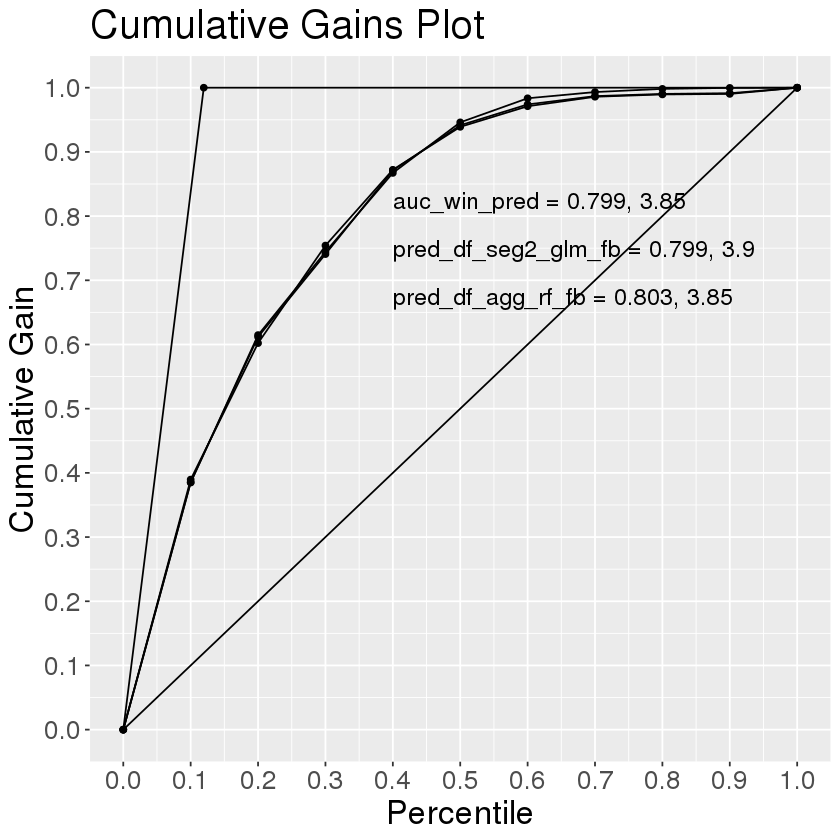

In [356]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.1194494) 

In [358]:
dim(expiry_test_predictions_assign)

[1] 60511    64

In [359]:
lift_df

P,actu_renwd2,gain,lift,actu_renwd2_ seg2_glm_fb,gain_ seg2_glm_fb,lift_ seg2_glm_fb,actu_renwd2_ agg_rf_fb,gain_ agg_rf_fb,lift_ agg_rf_fb
<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
0.1,2785,0.3853071,3.853071,2816,0.3895960,3.895960,2782,0.3848921,3.848921
0.2,4422,0.6117875,3.058937,4352,0.6021029,3.010515,4443,0.6146929,3.073464
0.3,5354,0.7407305,2.469102,5451,0.7541505,2.513835,5379,0.7441893,2.480631
0.4,6297,0.8711954,2.177988,6304,0.8721638,2.180410,6268,0.8671832,2.167958
0.5,6805,0.9414776,1.882955,6787,0.9389873,1.877975,6838,0.9460432,1.892086
0.6,7040,0.9739900,1.623317,7019,0.9710847,1.618474,7109,0.9835362,1.639227
0.7,7133,0.9868567,1.409795,7126,0.9858882,1.408412,7179,0.9932208,1.418887
0.8,7158,0.9903154,1.237894,7152,0.9894853,1.236857,7215,0.9982014,1.247752
0.9,7166,0.9914222,1.101580,7158,0.9903154,1.100350,7226,0.9997233,1.110804


In [361]:
as.data.frame(auc_list)

auc_win_pred,pred_df_seg2_glm_fb,pred_df_agg_rf_fb
<dbl>,<dbl>,<dbl>
0.7993082,0.7993774,0.8031682
